# Business Objective

Prediksi kinerja saham IPO untuk jangka pendek (1d, 1w), jangka menengah (1m), jangka panjang (6m, 1y)

Potensi manfaat:
- Untuk perusahaan yang ingin IPO
- Untuk investor yang ingin mengikuti IPO

Dalam memprediksinya, kami menggunakan:
- Informasi umum perusahaan
- Informasi IPO perusahaan
- Data keuangan perusahaan

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## Load Data

In [440]:
df = pd.read_csv("../Filip/mod_data.csv")

df.head()

,Ticker,Nama Perusahaan,Tanggal Listing,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,...,Total Liabilitas,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %
0,UNIQ,PT Ulima Nitra Tbk,8-Mar-21,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,...,2.670000e+11,2.710000e+11,2.454700e+10,-5.617000e+09,118,999,35,5.0,-25.0,-30.0
1,GTRA,PT Grahaprima Suksesmandiri Tbk,30-Mar-23,Transportation & Logistic,PT UOB Kay Hian Sekuritas,pengembangan,lainnya,1.894375e+09,0.2000,modal belanja,...,4.570000e+11,1.950000e+11,8.756900e+10,1.130000e+11,150,999,85,77.0,39.0,9.0
2,BSBK,PT Wulandari Bangun Laksana Tbk,8-Nov-22,Properties & Real Estate,PT KGI Sekuritas Indonesia; PT Panca Global Se...,pengembangan,lainnya,2.275000e+10,0.1209,modal kerja,...,1.120000e+12,5.590600e+10,3.895000e+10,-1.943000e+09,100,999,170,140.0,-50.0,-50.0
3,COAL,PT Black Diamond Resources Tbk,7-Sep-22,Energy,PT Surya Fajar Sekuritas,pemantauan khusus,lainnya,6.250000e+09,0.2000,modal kerja,...,2.500000e+14,9.553076e+10,4.902891e+10,4.330173e+10,100,999,280,354.0,36.0,-45.0
4,CRAB,PT Toba Surimi Industries Tbk,10-Aug-22,Consumer Non-Cyclicals,PT KGI Sekuritas Indonesia,pengembangan,lainnya,1.950000e+09,0.2000,modal kerja,...,2.470000e+11,1.360000e+11,1.738746e+10,2.926422e+09,150,999,56,59.0,41.0,59.0


In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Small Explanations:

This's a classification problem to classify this target columns:

- **Harga Final**: Harga final penawaran saham yang ditetapkan
- **1D %**: Persentase keuntungan / kerugian harga saham pada hari pertama perdagangan. (Ngukur initial pop sebuah IPO)
    - Multiclass Classification:
        'ARA': kinerja luar biasa, harga menyentuh batas kenaikan harian.
        'Naik': kinerja positif, tidak mencapai ARA
        'Turun': kinerja negatif
- **1W %**
- **1M %**
- **6M %**
- **1Y %**

Sisanya literally persentase keuntungan dan kerugian saham berdasarkan periode waktu.

## Exploratory Data Analysis & Preprocessing

### 1. Ubah beberapa kolom ke dalam float

In [442]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

### 2. Menghilangkan persentase ("%")

In [443]:
cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

### 3. Missing Value

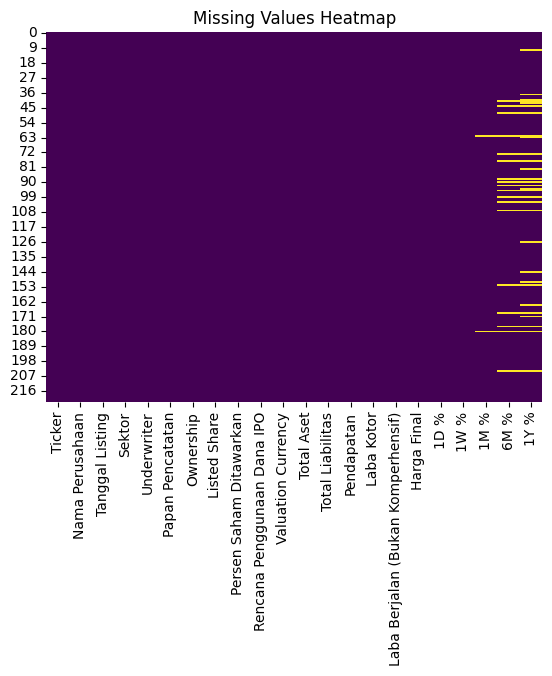

In [444]:
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Creating a Classification Problem

1. Mengubah kolom 1D % dari numerik menjadi kategorikal berdasarkan ARA.

    **Dalam dataset, 999 mengindikasikan saham tersebut ARA pada hari pertama

    Jika 1D % == 999 -> maka kita ubah jadi ARA, sedangkan kalau 1D % > 0 -> maka kita ubah jadi plus, dan kalau 1D % < 0, kita ubah jadi minus.

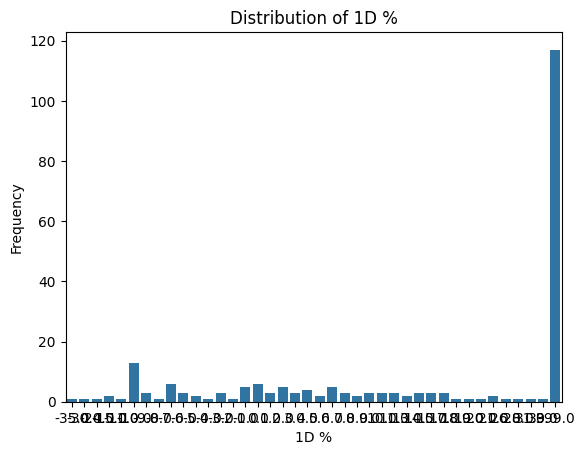

In [445]:
sns.countplot(x="1D %", data=df)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

note ARA:
- < 200: +35%
- 200-4999: +25%
- .> 4999: +20%

Sekarang kalau kita ubah:

In [446]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

Maka, akan menjadi kolom kategorikal dengan distribusi sebagai berikut:

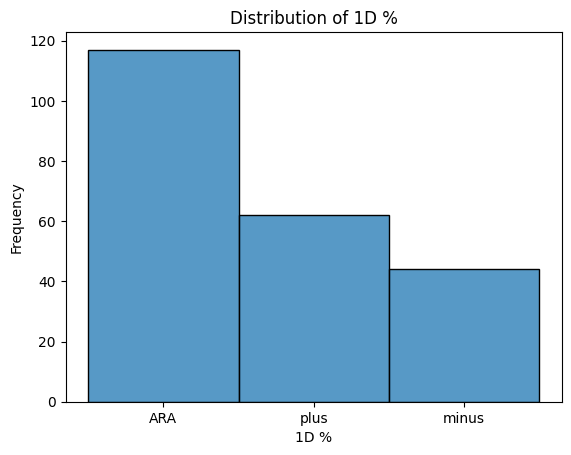

In [447]:
sns.histplot(df["1D %"], bins=30)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Untuk kolom target seperti 1W %, 1M %, 6M %, dan 1Y% masih merupakan kolom numerik. Jadi, kita dapat cek distribusi-nya terlebih dahulu.

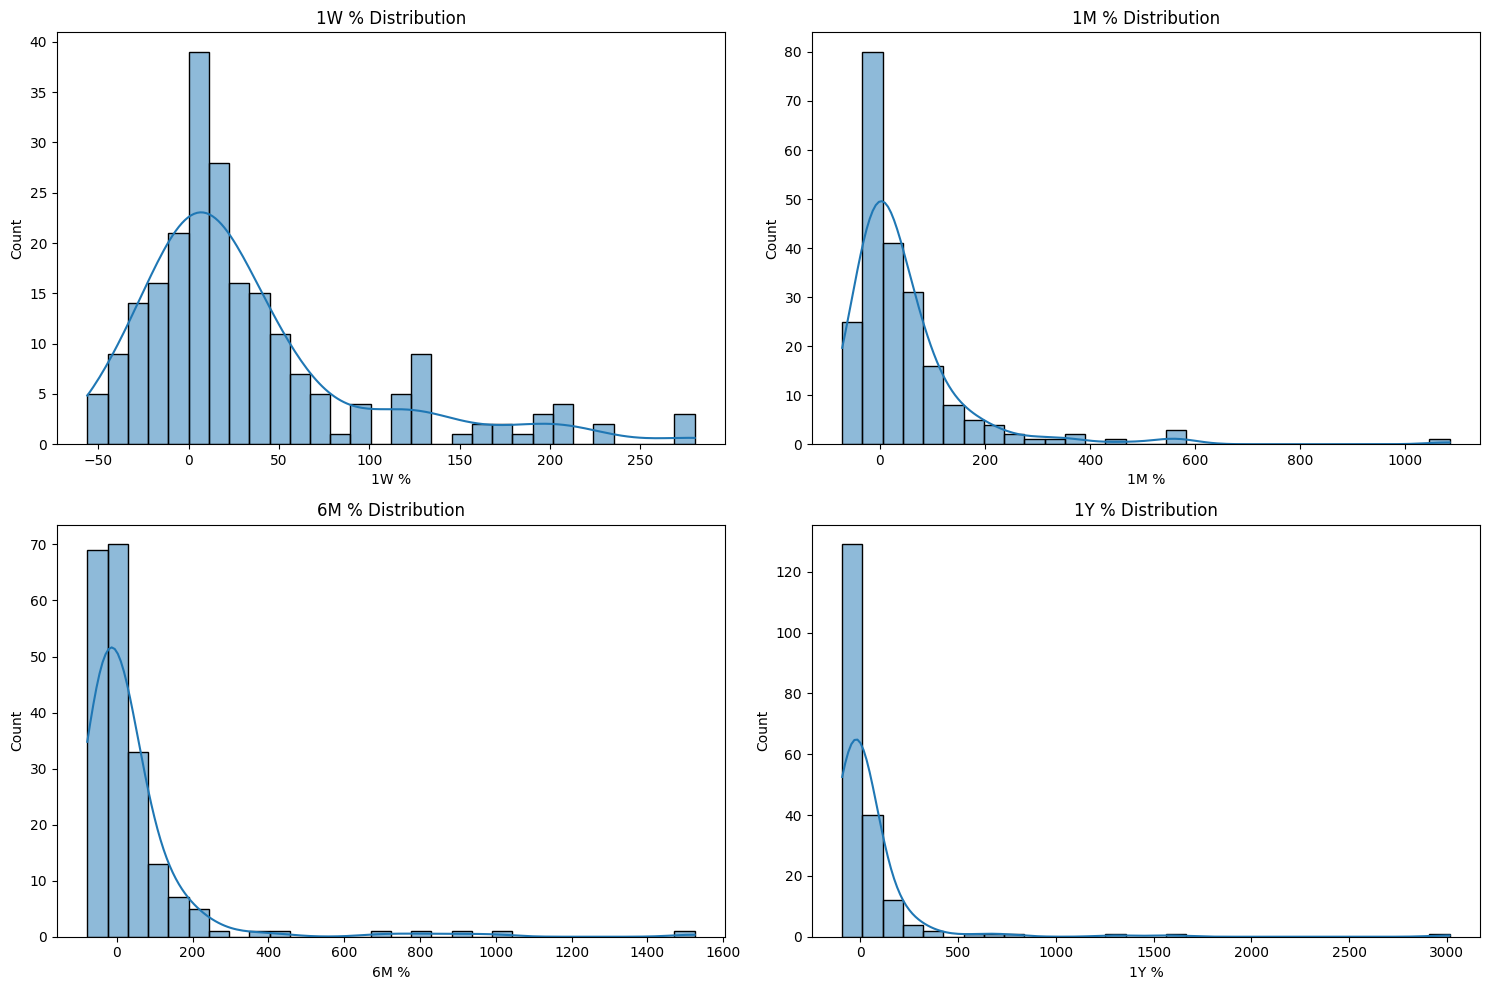

In [448]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['1W %'].dropna(), bins=30, ax=ax[0, 0], kde=True)
sns.histplot(df['1M %'].dropna(), bins=30, ax=ax[0, 1], kde=True)
sns.histplot(df['6M %'].dropna(), bins=30, ax=ax[1, 0], kde=True)
sns.histplot(df['1Y %'].dropna(), bins=30, ax=ax[1, 1], kde=True)
ax[0, 0].set_title('1W % Distribution')
ax[0, 1].set_title('1M % Distribution')
ax[1, 0].set_title('6M % Distribution')
ax[1, 1].set_title('1Y % Distribution')
plt.tight_layout()
plt.show()

Ubah kolom 1W % dan kolom 1M % menjadi 2 kategori yaitu good dan bad

In [449]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)

Ubah kolom 6M % dan kolom 1Y % menjadi 2 kategori yaitu plus dan minus

In [450]:
def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'
    
for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

#### Conclusions

Jadi, kita punya sekarang punya target label berupa kategorikal columns.

In [451]:
custom_orders = {
    '1D %': ['ARA', 'plus', 'minus'],
    '1W %': ['good', 'bad'],
    '1M %': ['good', 'bad'],
    '6M %': ['plus', 'minus'],
    '1Y %': ['plus', 'minus']
}

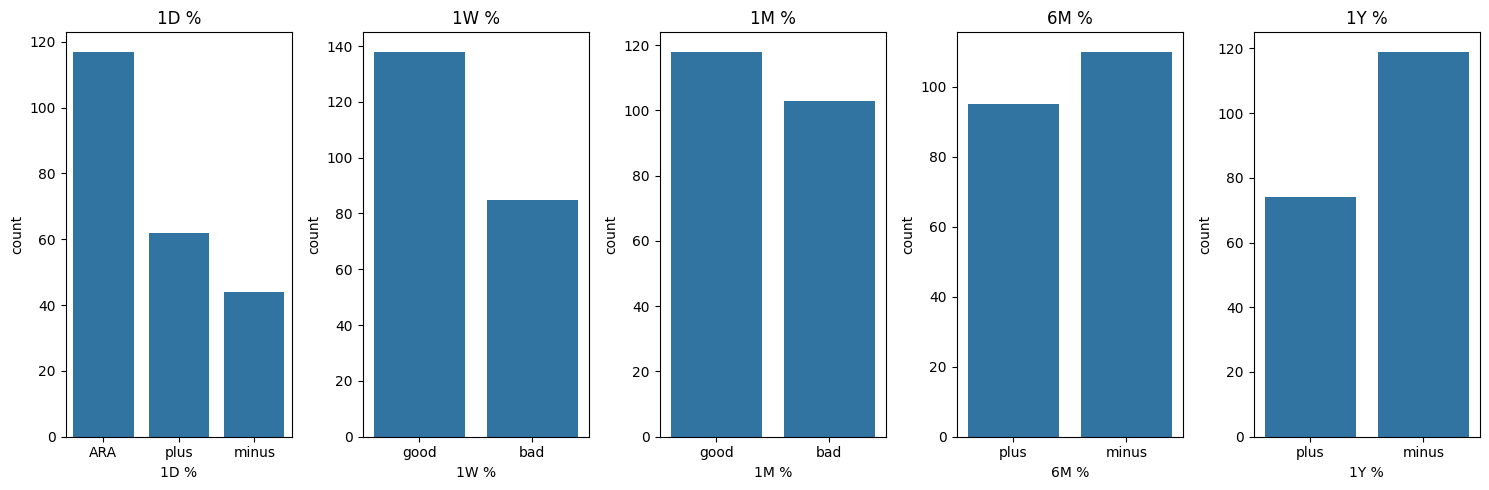

In [452]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(cols):
    sns.countplot(
        x=col,
        data=df,
        ax=ax[i],
        order=custom_orders.get(col)
    )
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

### 1. Datetime

In [453]:
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
df.sort_values('Tanggal Listing', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Ticker,Nama Perusahaan,Tanggal Listing,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,...,Total Liabilitas,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %
0,UNIQ,PT Ulima Nitra Tbk,2021-03-08,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,...,2.670000e+11,2.710000e+11,2.454700e+10,-5.617000e+09,118.0,ARA,good,good,minus,minus
1,ARCI,PT Archi Indonesia Tbk,2021-06-28,Basic Materials,PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...,pengembangan,konglomerat,2.483500e+10,0.1500,bayar hutang,...,6.860000e+12,4.960000e+12,2.710000e+12,1.490000e+12,750.0,plus,bad,bad,minus,minus
2,MASB,PT Bank Multiarta Sentosa Tbk,2021-06-30,Financials,PT BCA Sekuritas,pemantauan khusus,lainnya,1.226903e+09,0.1500,modal kerja,...,1.960000e+13,1.210000e+12,4.310000e+11,1.080000e+11,3360.0,ARA,bad,bad,plus,plus
3,BMHS,PT Bundamedik Tbk,2021-07-06,Healthcare,PT Ciptadana Sekuritas Asia,utama,konglomerat,8.603416e+09,0.0726,bayar hutang,...,1.110000e+12,1.150000e+12,3.680000e+11,1.180000e+11,340.0,ARA,good,good,plus,plus
4,UVCR,PT Trimegah Karya Pratama Tbk,2021-07-27,Technology,PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...,pengembangan,lainnya,2.000000e+09,0.2500,modal belanja,...,1.435880e+10,1.940000e+11,4.634337e+09,5.434916e+08,100.0,ARA,good,good,plus,plus


### 2. Underwriter

Ini part/fitur paling penting yang jadi patokan orang-orang dalam menentukan apakah dia akan beli saham atau engga.

Insight yang didapat:
- Underwriter mampu membawa harga saham naik.
- Underwriter yang secara historikal dia ampir selalu ngebawa harga sahamnya naik (contohnya ciptadana, trimegah, henan) -> **Ini yang wajib kita catat**
- Underwriter berupa bank gede (biasanya saham yang di bawa dia cenderung sideways (ga naik, ga turun)) (contohnya bca, bri, bni)
- Semakin sering underwriter menjadi bagian yang mempengaruhi saham, semakin tinggi orang-orang pada mau beli tu saham.


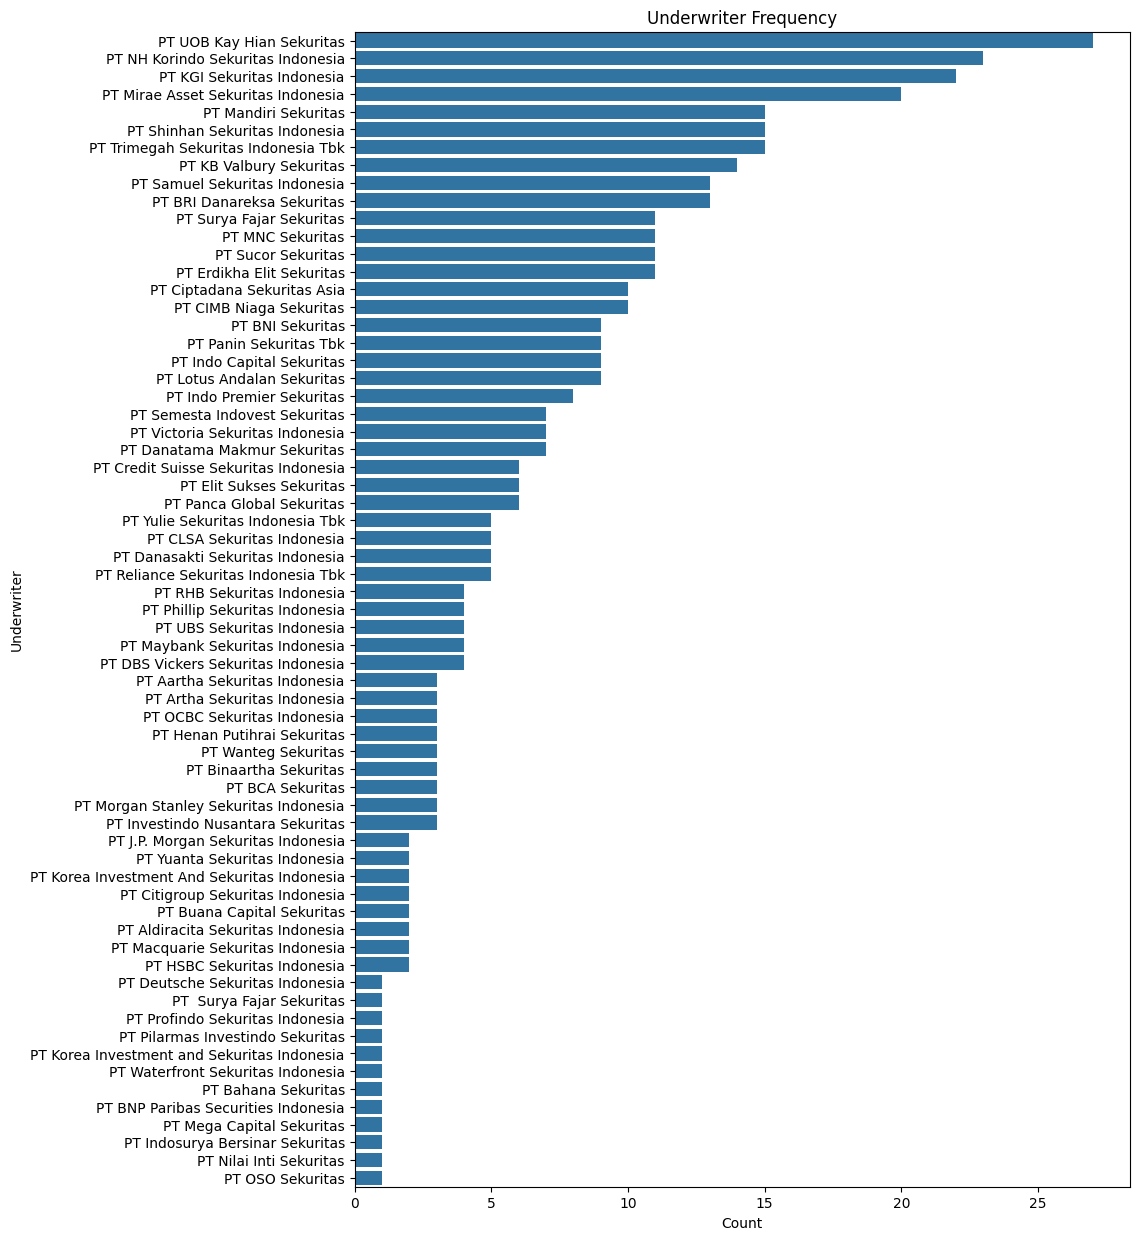

In [454]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()

Sekarang, kita bisa melihat:
1. Underwriter mana yang:
    - paling aktif `freq`
    - cenderung menangani perusahaan besar `avg_aset`
    - mengelola penawaran saham bernilai tinggi `avg_jumlah`
2. Spesialisasi underwriter (apakah ada underwriter yang spesialis di sektor perusahaan dengan aset besar atau kecil?)

Ini juga bakal jadi pertimbangan buat perusahaan buat milih underwriter yang tepat buat perusahaan dia.

In [455]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']
    
    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12


In [456]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11,low,high
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12,high,high
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12,high,high
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12,high,low
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12,high,mid


Sekarang, kita akan mengelompokkan para underwriter berdasarkan dua metrik yang sudah dihitung sebelumnya:
- rata-rata aset
- frekuensi

Pengelompokkan akan dilakukan menggunakan metode kuantil untuk membagi underwriter ke 3 grup yaitu `high`, `mid`, dan `low`

In [457]:
high_aset = uw_df['avg_aset'].quantile(0.5)
low_aset = uw_df['avg_aset'].quantile(0.25)

In [458]:
print("Quantiles for 'avg_aset':")
print(uw_df['avg_aset'].quantile([0, 0.25, 0.5, 0.75, 1]))

Quantiles for 'avg_aset':
0.00    1.518612e+10
0.25    3.061191e+11
0.50    6.012731e+12
0.75    1.953000e+13
1.00    1.480000e+14
Name: avg_aset, dtype: float64


In [459]:
def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'
    
uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

In [460]:
high_freq = uw_df['freq'].quantile(0.5)
low_freq = uw_df['freq'].quantile(0.25)

In [461]:
print("\nQuantiles for 'freq':")
print(uw_df['freq'].quantile([0, 0.25, 0.5, 0.75, 1]))


Quantiles for 'freq':
0.00     1.0
0.25     2.0
0.50     4.0
0.75     9.0
1.00    27.0
Name: freq, dtype: float64


In [462]:
def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)

Final check:

In [463]:
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11,low,high
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12,high,high
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12,high,high
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12,high,low
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12,high,high


Oke, sekarang kita tinggal implementasiin aja ke dataset asli kita.

1. Buat dictionary berdasarkan `freq` dan `avg` tadi buat di mapping.

In [464]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

3. Buat kategorikal kolom baru (2 buah) dengan mapping dictionary yang tadi.
- Disini, yang diambil adalah max value dari setiap underwriter suatu IPO

In [465]:
cat_order = {'low': 0, 'mid': 1, 'high': 2}
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

def max_category(uw_str, uw_map):
    uws = [u.strip() for u in uw_str.split(';') if u.strip()]
    cats = [uw_map.get(u) for u in uws if uw_map.get(u) is not None]
    if not cats:
        return np.nan
    return max(cats, key=lambda x: cat_order[x])

df['underwriter_freq_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_freq_cat))
df['underwriter_avg_aset_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_aset_cat))

Sekarang, kita akan cek performa saham dengan kategori underwriter yang udah kita buat.

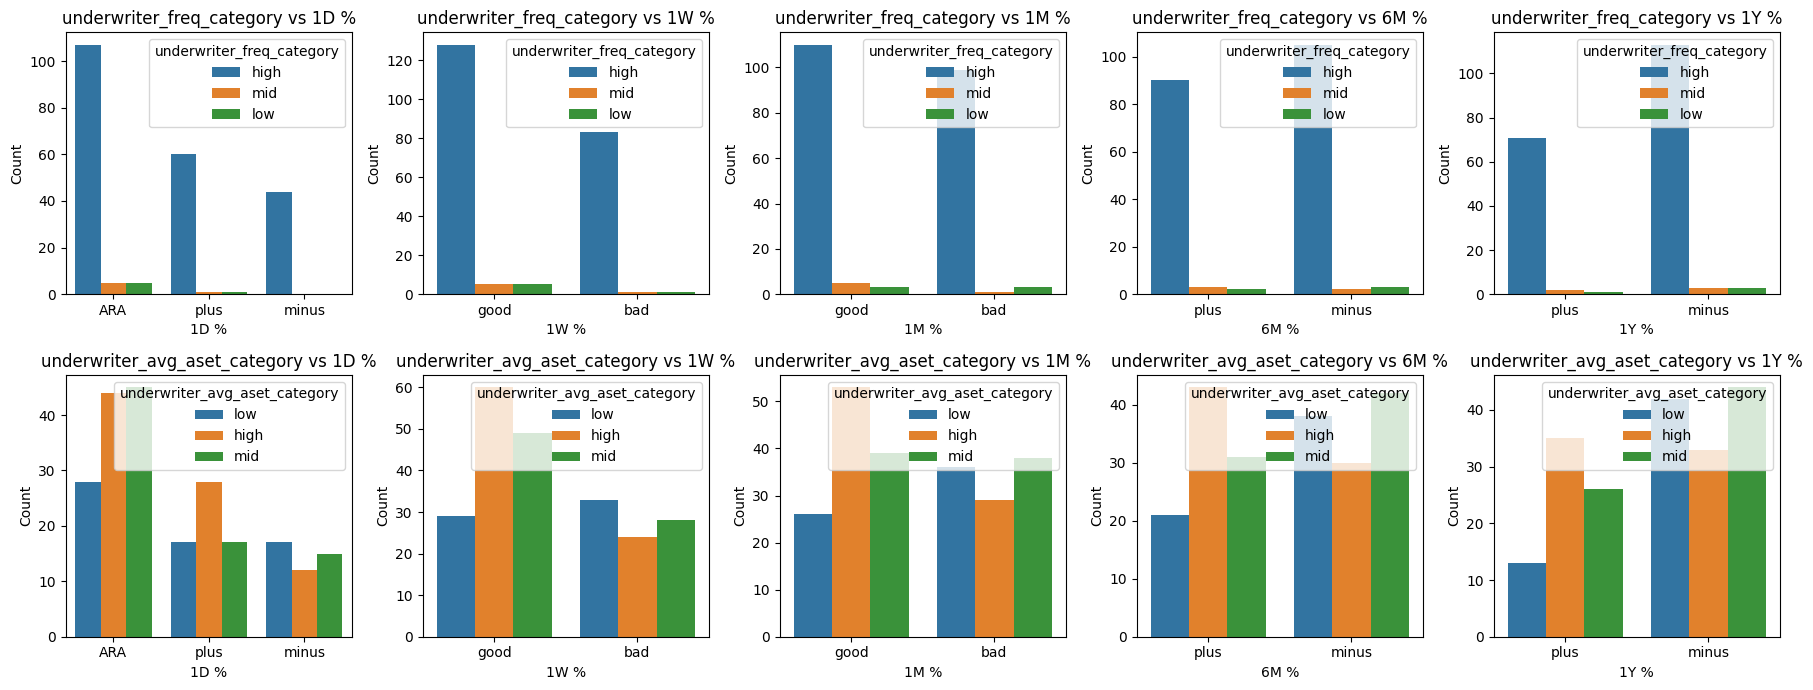

In [466]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))

target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']


for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=target, hue=col, data=df, order=custom_orders.get(target),  ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()


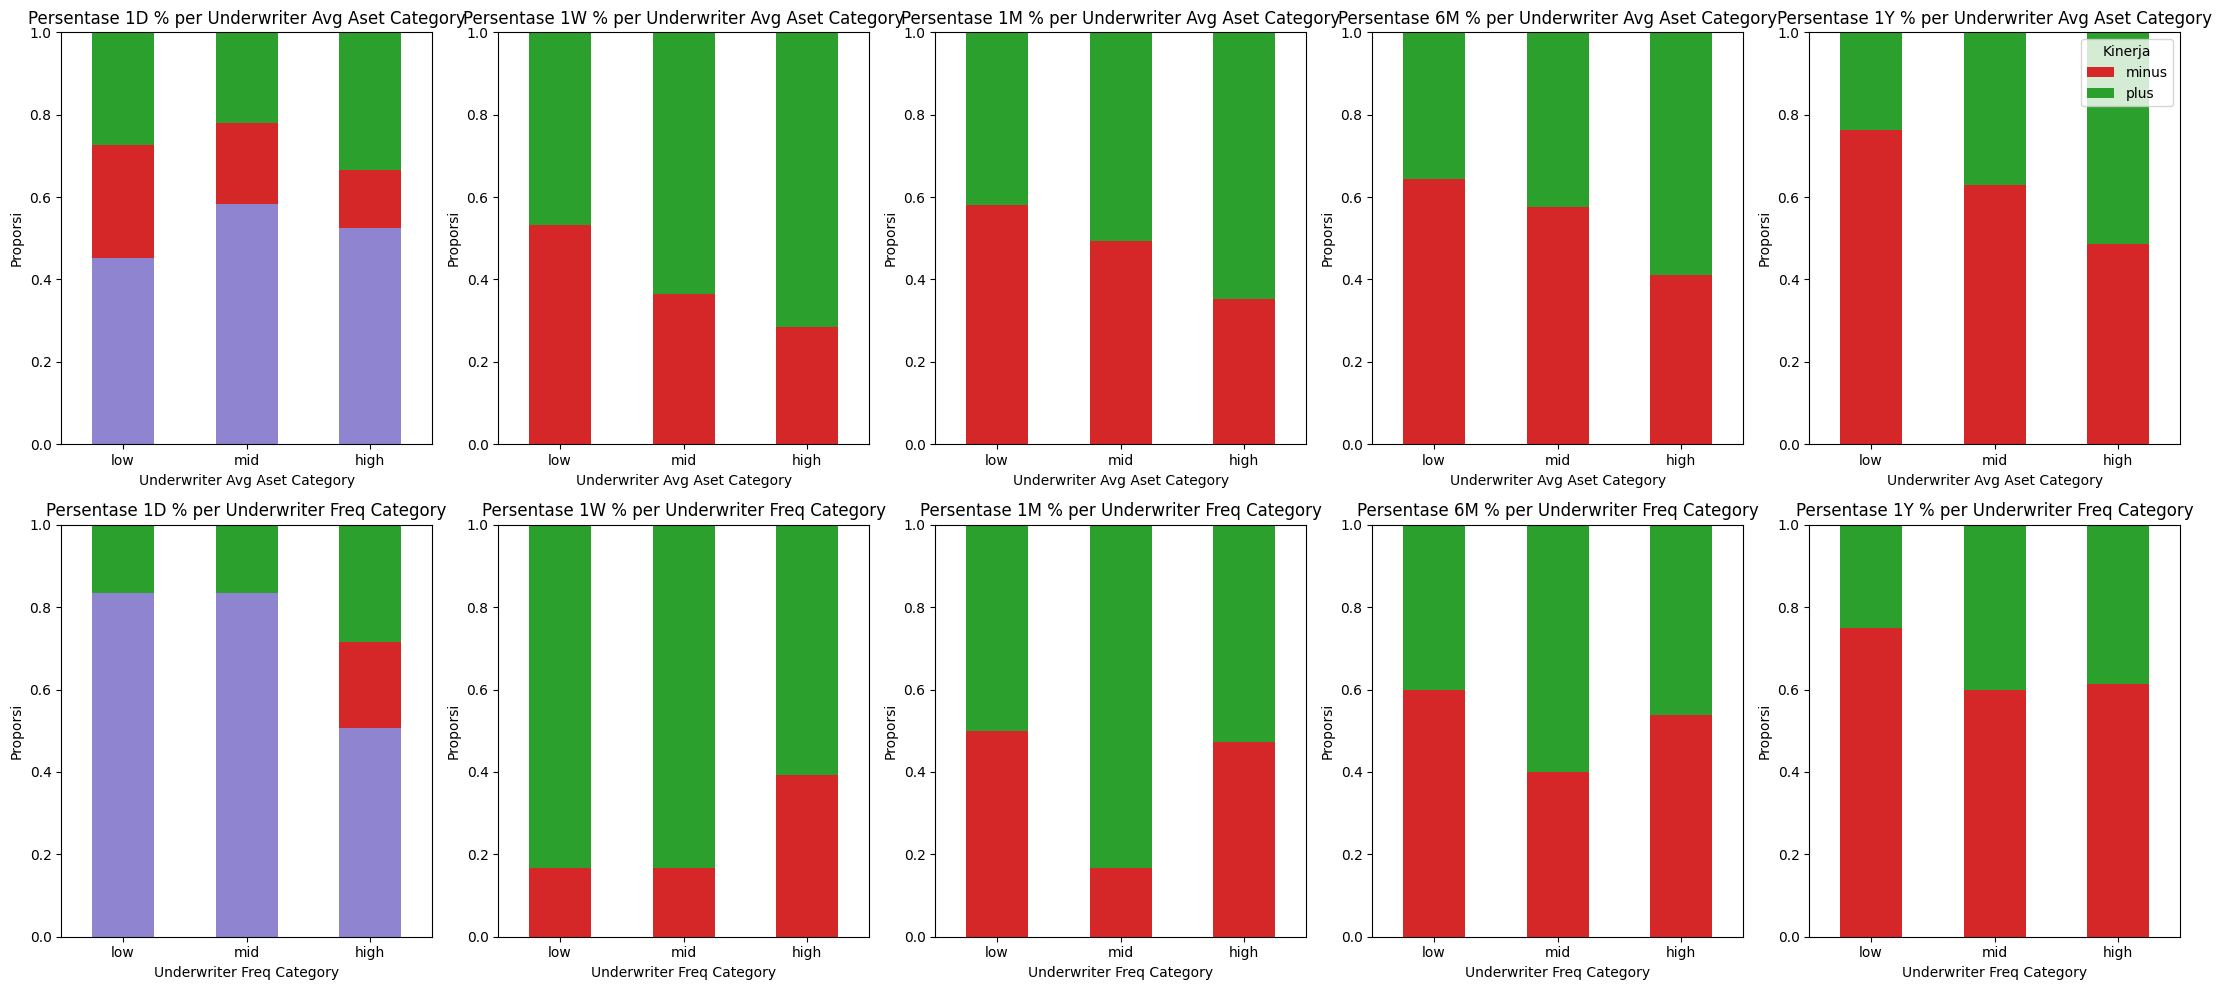

In [467]:
periods = ['1D %', '1W %', '1M %', '6M %', '1Y %']
custom_colors = {
    'minus': '#d62728',
    'plus': '#2ca02c',
    'ARA': "#17009c7b",
    'bad': '#d62728',
    'good': '#2ca02c',
}
cat_order_list = ['low', 'mid', 'high']

fig, axes = plt.subplots(2, len(periods), figsize=(22, 10))

for row_idx, cat_col in enumerate(['underwriter_avg_aset_category', 'underwriter_freq_category']):
    for i, period in enumerate(periods):
        ct_prop = (
            df.groupby(cat_col)[period]
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
        )
        ct_prop = ct_prop.reindex(cat_order_list)
        labels = ct_prop.columns.tolist()
        color_list = [custom_colors.get(label, '#333333') for label in labels]
        ct_prop[labels].plot(
            kind='bar',
            stacked=True,
            color=color_list,
            ax=axes[row_idx, i],
            legend=False
        )
        axes[row_idx, i].set_title(f'Persentase {period} per {cat_col.replace("_", " ").title()}')
        axes[row_idx, i].set_xlabel(cat_col.replace("_", " ").title())
        axes[row_idx, i].set_ylabel('Proporsi')
        axes[row_idx, i].set_ylim(0, 1)
        axes[row_idx, i].set_xticklabels(cat_order_list, rotation=0)

axes[0, -1].legend(labels, title='Kinerja', loc='upper right')
plt.tight_layout()
plt.show()


**Apakah ada hubungan antara tipe underwriter (berdasarkan frekuensi atau aset klien) dengan kinerja harga saham IPO dalam jangka pendek hingga panjang?**

Insight:
1. 1D % tidak terlalu terlihat polanya jika dari frekuensi underwriter membawakan IPO dan rata-rata besarnya perusahaan yang biasa dibawahakannya.
2. Underwriter yang biasanya membawakan perusahaan-perusahaan yang lebih besar cenderung memberikan kinerja yang lebih baik. Namun, ini dapat juga dikarenakan
   perusahaan yang lebih besar cenderung lebih baik kinerja IPO nya.
2. Frekuensi underwriter tidak terlalu terlihat polanya terhadap kinerja saham IPO yang dibawakannya.

Kemudian, ini yang kategoriin underwriter mana yang bagus, dibagi ke 3 kategori alpha(bagus) beta(lumayan) gamma(sisa). bikin kategorinya 3 biji, buat short term (1D), mid term (1M), long term (1Y)

In [468]:
label_cols = [
    '1D_ARA', '1D_plus', '1D_minus',
    #'1W_good', '1W_bad',
    '1M_good', '1M_bad',
    #'6M_plus', '6M_minus',
    '1Y_plus', '1Y_minus'
]

for col in label_cols:
    uw_df[col] = 0

uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category,1D_ARA,1D_plus,1D_minus,1M_good,1M_bad,1Y_plus,1Y_minus
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11,low,high,0,0,0,0,0,0,0
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12,high,high,0,0,0,0,0,0,0
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12,high,high,0,0,0,0,0,0,0
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12,high,low,0,0,0,0,0,0,0
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12,high,high,0,0,0,0,0,0,0


In [469]:
def reset_label_cols(uw_df, label_cols):
    uw_df[label_cols] = 0
    return uw_df

In [470]:
def update_uw_df_counts(df, uw_df):
    for idx, row in df.iterrows():
        val_1d = row['1D %']
        val_1m = row['1M %']
        val_1y = row['1Y %']
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        for uw in underwriters:
            uw_idx = uw_df[uw_df['underwriter'] == uw].index
            if not uw_idx.empty:
                uw_idx = uw_idx[0]

                if val_1d in ['ARA', 'plus', 'minus']:
                    col_1d = f"1D_{val_1d}"
                    if col_1d in uw_df.columns:
                        uw_df.at[uw_idx, col_1d] += 1

                if val_1m in ['good', 'bad']:
                    col_1m = f"1M_{val_1m}"
                    if col_1m in uw_df.columns:
                        uw_df.at[uw_idx, col_1m] += 1

                if val_1y in ['plus', 'minus']:
                    col_1y = f"1Y_{val_1y}"
                    if col_1y in uw_df.columns:
                        uw_df.at[uw_idx, col_1y] += 1
    return uw_df

In [471]:
uw_df['short_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1D_ARA'] * 1 + uw_df['1D_minus'] * -1 + uw_df['1D_plus'] * 0.25

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1D_ARA'])
        + float(uw_df.at[top_uw_idx, '1D_plus'])
        + float(uw_df.at[top_uw_idx, '1D_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = (
            float(uw_df.at[top_uw_idx, '1D_ARA'])
            + 0.25 * float(uw_df.at[top_uw_idx, '1D_plus'])
        ) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.66 and (uw_df.at[top_uw_idx, '1D_ARA'] >= (uw_df.at[top_uw_idx, '1D_minus'] + uw_df.at[top_uw_idx, '1D_plus'])):
        uw_df.at[top_uw_idx, 'short_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'short_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]


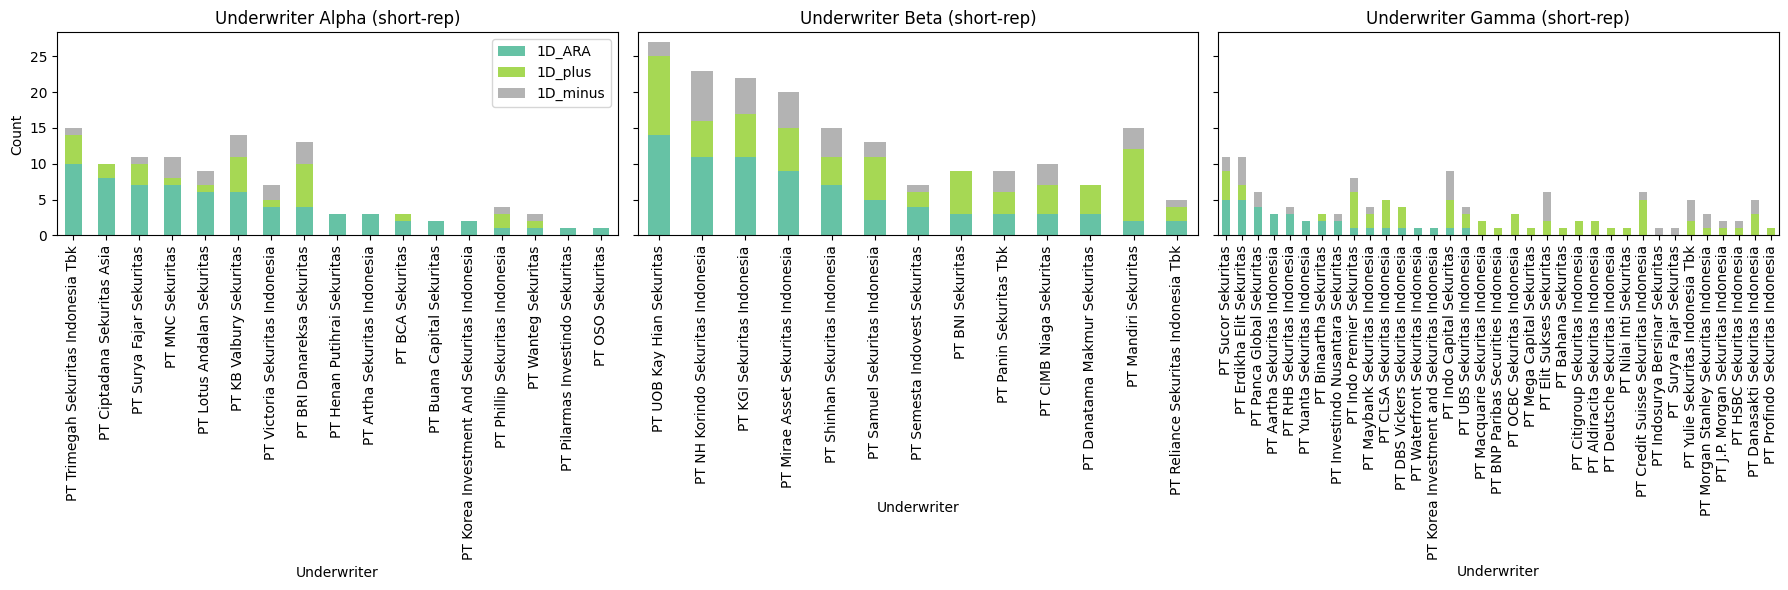

In [472]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)
    
groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['short_rep'] == group][['underwriter', '1D_ARA', '1D_plus', '1D_minus']]
    subset = subset.sort_values('1D_ARA', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1D_ARA', '1D_plus', '1D_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (short-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [473]:
uw_df['mid_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1M_good'] * 1 + uw_df['1M_bad'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1M_good'])
        + float(uw_df.at[top_uw_idx, '1M_bad'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1M_good']) / denominator

    if percentage_score < 0.5:
        break
    if percentage_score > 0.66:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]


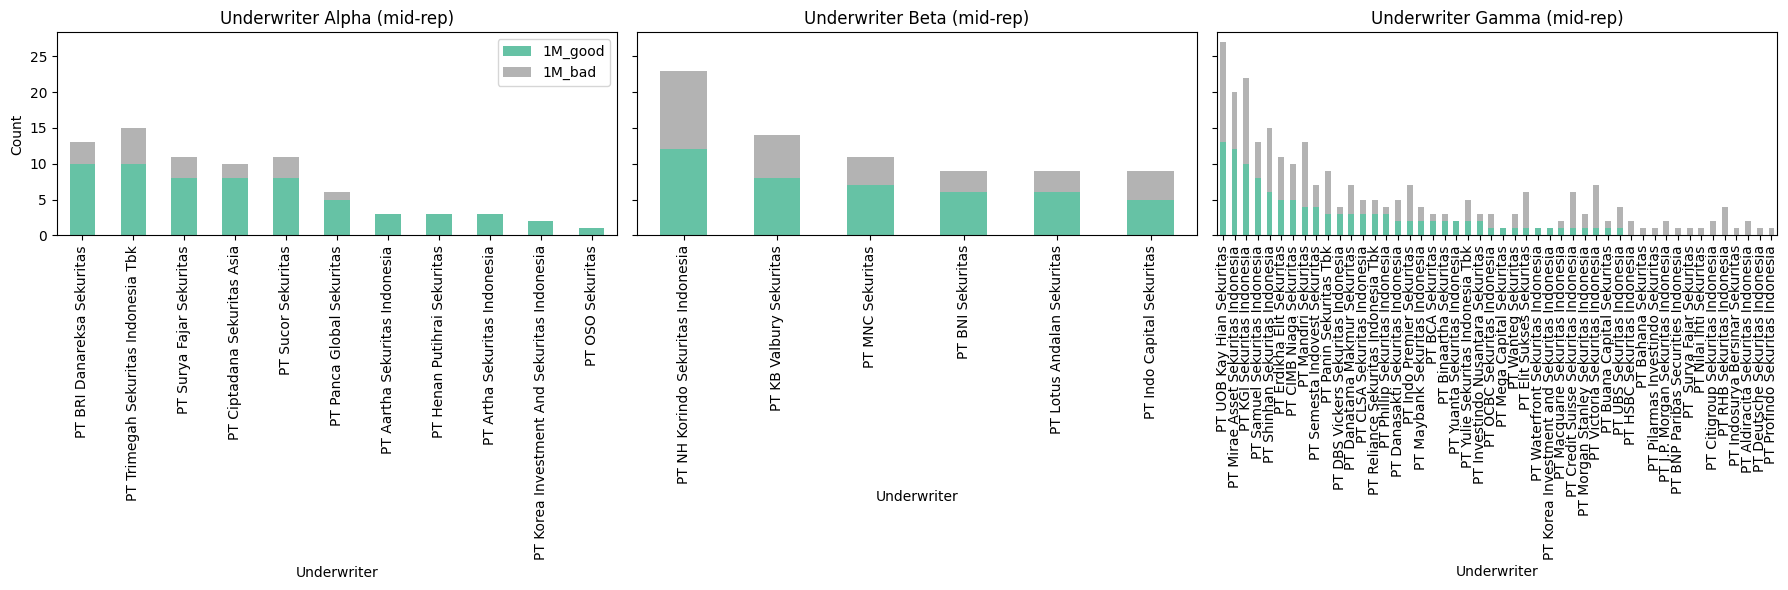

In [474]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['mid_rep'] == group][['underwriter', '1M_good', '1M_bad']]
    subset = subset.sort_values('1M_good', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1M_good', '1M_bad']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (mid-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [475]:
uw_df['long_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1Y_plus'] * 2 + uw_df['1Y_minus'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1Y_plus'])
        + float(uw_df.at[top_uw_idx, '1Y_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1Y_plus']) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.55:
        uw_df.at[top_uw_idx, 'long_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'long_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

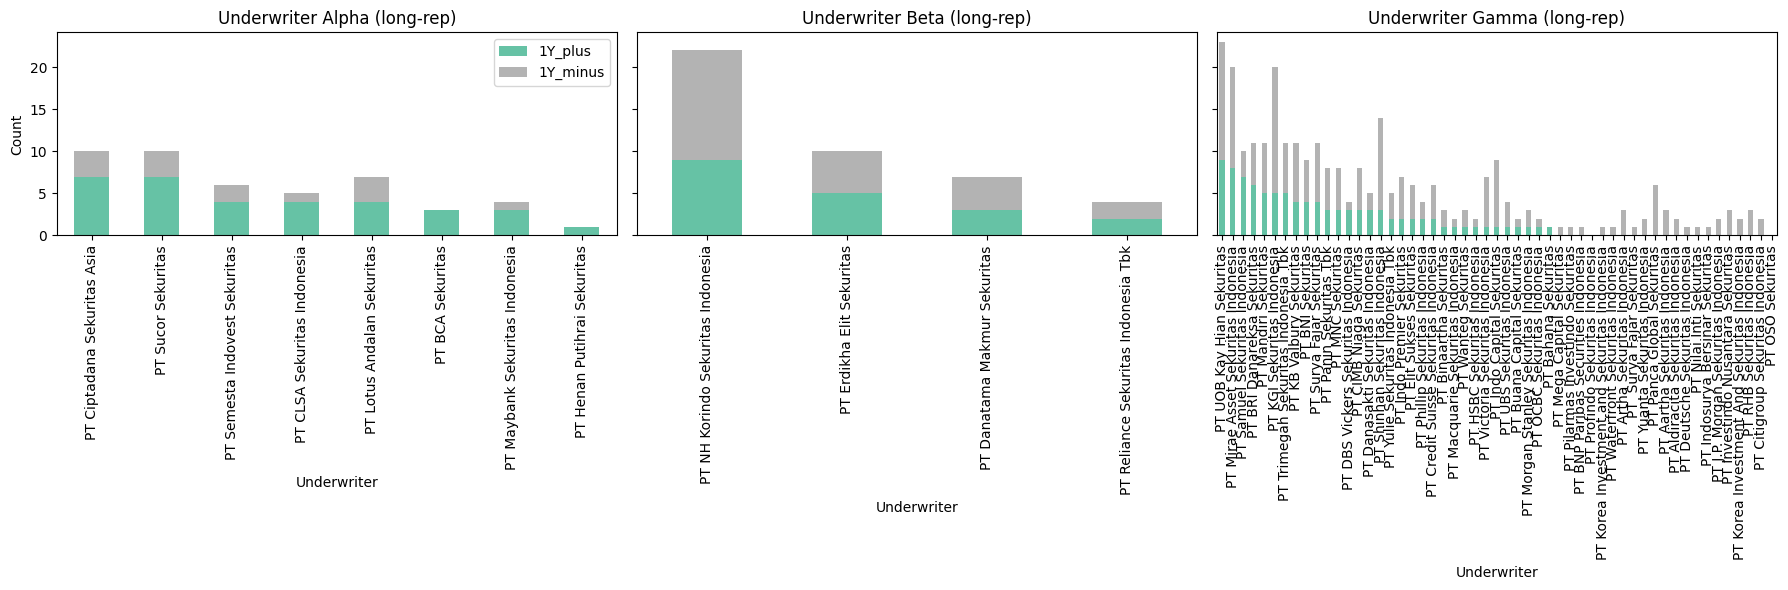

In [476]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['long_rep'] == group][['underwriter', '1Y_plus', '1Y_minus']]
    subset = subset.sort_values('1Y_plus', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1Y_plus', '1Y_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (long-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [477]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)
uw_df = uw_df.drop(columns=['score'], errors='ignore')

Untuk pada dataset IPO, 'underwriter_highest_tier' melambangkan rank tertinggi underwriter yang ada, sedangkan 'underwriter_bigbank' menandakan ada big bank atau tidak pada underwriternya.

In [478]:
tier_rank = {'alpha': 1, 'beta': 2, 'gamma': 3}
rank_to_tier = {v: k for k, v in tier_rank.items()}

def process_row(row, uw_df, big_banks_sekuritas):
    underwriter_str = row.get('Underwriter', '')
    underwriters = [uw.strip() for uw in str(underwriter_str).split(';') if uw.strip()]
    
    uw_subset = uw_df[uw_df['underwriter'].isin(underwriters)]

    result = {}

    for rep_type in ['short', 'mid', 'long']:
        col = f'{rep_type}_rep'
        if not uw_subset.empty:
            tier_values = uw_subset[col].map(tier_rank).dropna()
            best_rank = tier_values.min()
            result[f'underwriter_highest_{rep_type}_rep'] = rank_to_tier[best_rank]
        else:
            result[f'underwriter_highest_{rep_type}_rep'] = None

    result['underwriter_has_bigbank'] = 'yes' if any(uw in big_banks_sekuritas for uw in underwriters) else 'no'

    return pd.Series(result)

new_cols = df.apply(lambda row: process_row(row, uw_df, big_banks_sekuritas), axis=1)
df = df.join(new_cols)

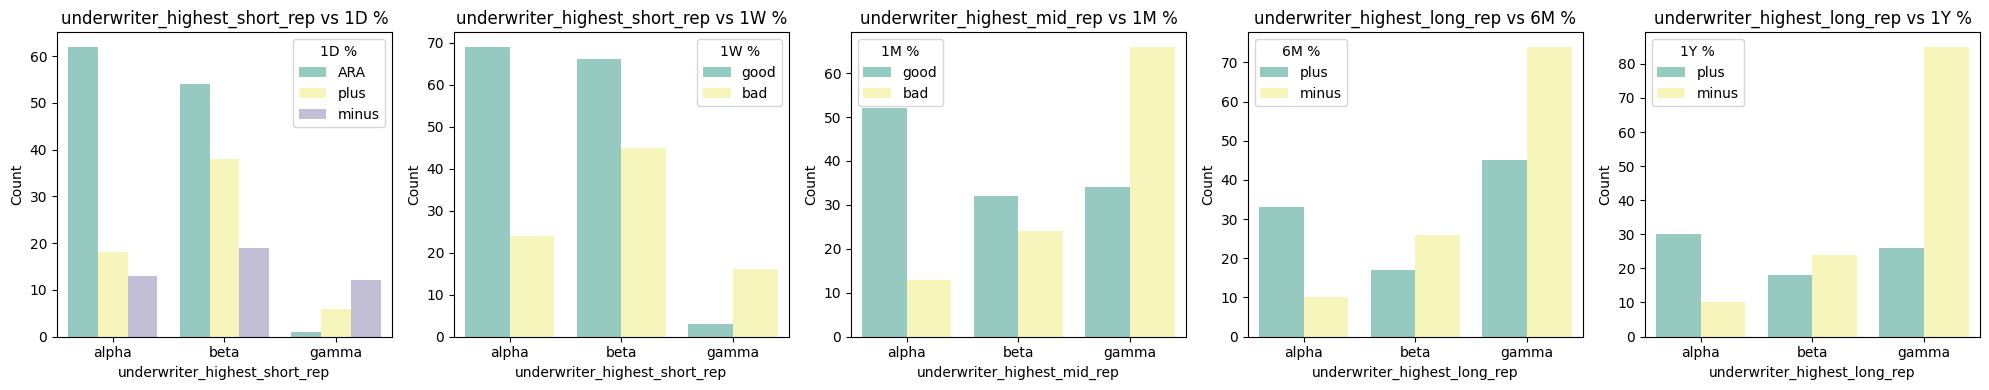

In [479]:
time_to_tier = {
    '1D %': 'underwriter_highest_short_rep',
    '1W %': 'underwriter_highest_short_rep',
    '1M %': 'underwriter_highest_mid_rep',
    '6M %': 'underwriter_highest_long_rep',
    '1Y %': 'underwriter_highest_long_rep',
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    x_col = time_to_tier[col]
    sns.countplot(x=df[x_col], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i],
                    order=['alpha', 'beta', 'gamma'],
                    palette='Set3'
                    )
    axes[i].set_title(f'{x_col} vs {col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

Kemudian, ditandakan juga apabila terdapat bank besar yang menjadi salah satu underwriter dari IPO nya.

In [480]:
big_banks_sekuritas = [
    'PT BNI Sekuritas',
    'PT Mandiri Sekuritas',
    'PT Citigroup Sekuritas Indonesia',
    'PT Credit Suisse Sekuritas Indonesia',
    'PT UOB Kay Hian Sekuritas',
    'PT BCA Sekuritas',
    'PT Mirae Asset Sekuritas Indonesia',
    'PT BRI Danareksa Sekuritas',
    'PT UBS Sekuritas Indonesia',
    'PT HSBC Sekuritas Indonesia',
    'PT J.P. Morgan Sekuritas Indonesia',
    'PT Morgan Stanley Sekuritas Indonesia',
    'PT CIMB Niaga Sekuritas',
    'PT CLSA Sekuritas Indonesia',
    'PT Maybank Sekuritas Indonesia',
    'PT DBS Vickers Sekuritas Indonesia',
    'PT Deutsche Sekuritas Indonesia',
    'PT Mega Capital Sekuritas',
    'PT Macquarie Sekuritas Indonesia',
    'PT BNP Paribas Securities Indonesia',
    'PT OCBC Sekuritas Indonesia'
]

In [481]:
uw_df['bigbank'] = 'no' 

for idx, row in uw_df.iterrows():
    uw = row['underwriter']
    
    if uw in big_banks_sekuritas:
        uw_df.at[idx, 'bigbank'] = 'yes'

uw_df['bigbank'] = uw_df['bigbank'].astype('object')


In [482]:
df['underwriter_has_bigbank'] = 'no'  

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    
    if any(uw in big_banks_sekuritas for uw in underwriters):
        df.at[idx, 'underwriter_has_bigbank'] = 'yes'

df['underwriter_has_bigbank'] = df['underwriter_has_bigbank'].astype('object')

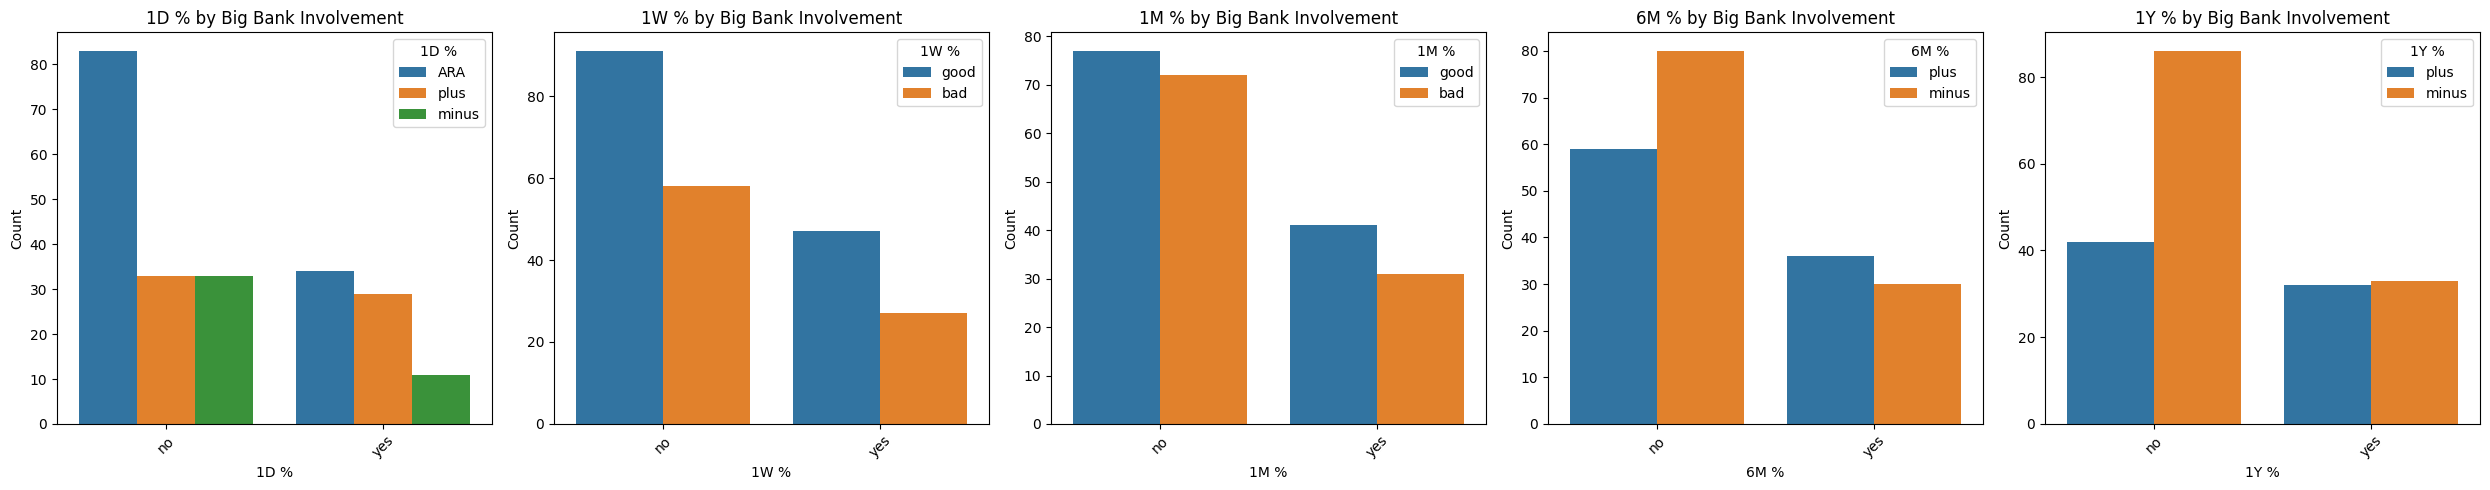

In [483]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(cols):
    sns.countplot(data=df, x='underwriter_has_bigbank', hue=col, hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f"{col} by Big Bank Involvement")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


- Untuk day 1, big bank terlihat lebih cenderung stabil saham IPO nya, sedangkan yang lainnya lebih volatil
- Terutama pada jangka panjang (6M, 1Y), bank besar terlihat mampu menjaga harganya dengan lebih baik

In [484]:
# uw_df.head(3)
# uw_df.to_csv("underwriter_stats.csv", index=False)

### 3. Seasonality

kolom yang mencatat kuartal saat saham listing

In [485]:
def month_to_quartal(month):
    if month in [1, 2, 3]:
        return 'I'
    elif month in [4, 5, 6]:
        return 'II'
    elif month in [7, 8, 9]:
        return 'III'
    elif month in [10, 11, 12]:
        return 'IV'
    else:
        return 'Unknown'

df['Listing Quartal'] = df['Tanggal Listing'].dt.month
df['Listing Quartal'] = df['Listing Quartal'].apply(month_to_quartal)
df = df.drop(columns=['Tanggal Listing'])
df['Listing Quartal'].value_counts()

Listing Quartal
I      71
III    66
IV     51
II     35
Name: count, dtype: int64

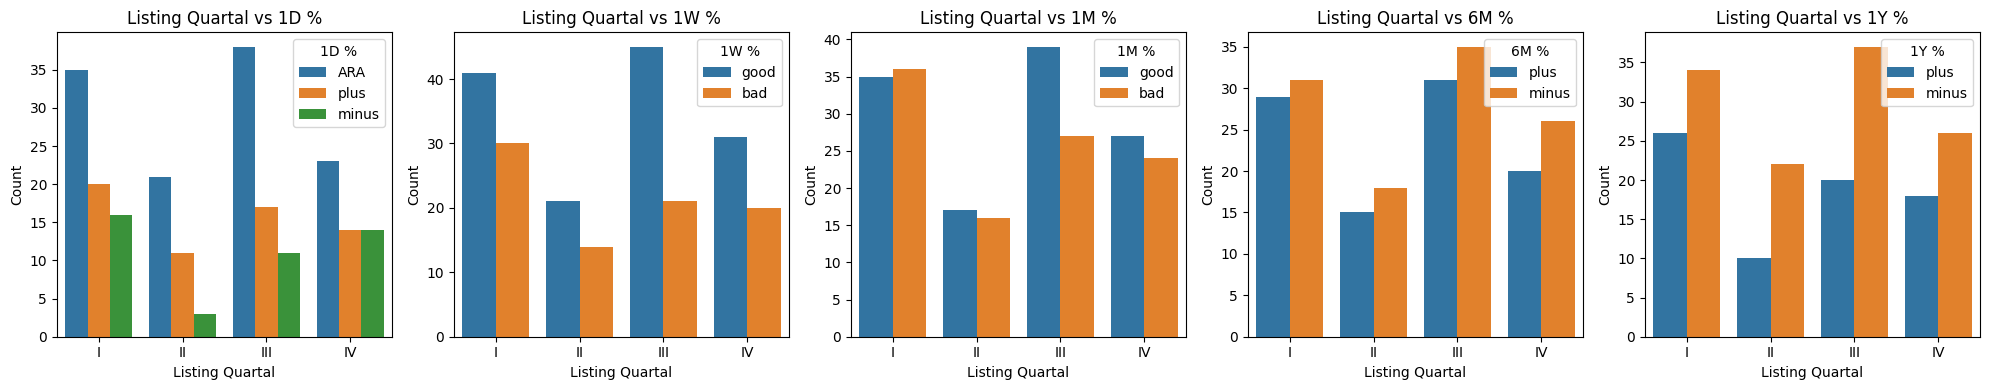

In [486]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Quartal'], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'Listing Quartal vs {col}')
    axes[i].set_xlabel('Listing Quartal')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

Dari countplot tersebut, tidak terlihat adanya pengaruh kuaral listing terhadap kinerja saham IPO.

### 4. Financials

In [487]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

In [488]:
df.head(5)

,Ticker,Nama Perusahaan,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,Valuation Currency,...,Listing Quartal,ipo_raised_fund,equity,leverage,turnover,PER,PBV,ROA,ROE,NPM
0,UNIQ,PT Ulima Nitra Tbk,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,rupiah,...,I,3.541024e+10,2.730000e+11,0.978022,0.501852,-65.942673,1.356777,-0.010402,-0.020575,-0.020727
1,ARCI,PT Archi Indonesia Tbk,Basic Materials,PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...,pengembangan,konglomerat,2.483500e+10,0.1500,bayar hutang,usd,...,II,2.793938e+12,2.220000e+12,3.090090,0.546256,12.500839,8.390203,0.164097,0.671171,0.300403
2,MASB,PT Bank Multiarta Sentosa Tbk,Financials,PT BCA Sekuritas,pemantauan khusus,lainnya,1.226903e+09,0.1500,modal kerja,rupiah,...,II,6.183591e+11,1.900000e+12,10.315789,0.056279,38.170315,2.169681,0.005023,0.056842,0.089256
3,BMHS,PT Bundamedik Tbk,Healthcare,PT Ciptadana Sekuritas Asia,utama,konglomerat,8.603416e+09,0.0726,bayar hutang,rupiah,...,III,2.123667e+11,1.050000e+12,1.057143,0.532407,24.789504,2.785868,0.054630,0.112381,0.102609
4,UVCR,PT Trimegah Karya Pratama Tbk,Technology,PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...,pengembangan,lainnya,2.000000e+09,0.2500,modal belanja,rupiah,...,III,5.000000e+10,3.083853e+10,0.465612,4.292289,100.000000,6.485393,0.012025,0.017624,0.002802


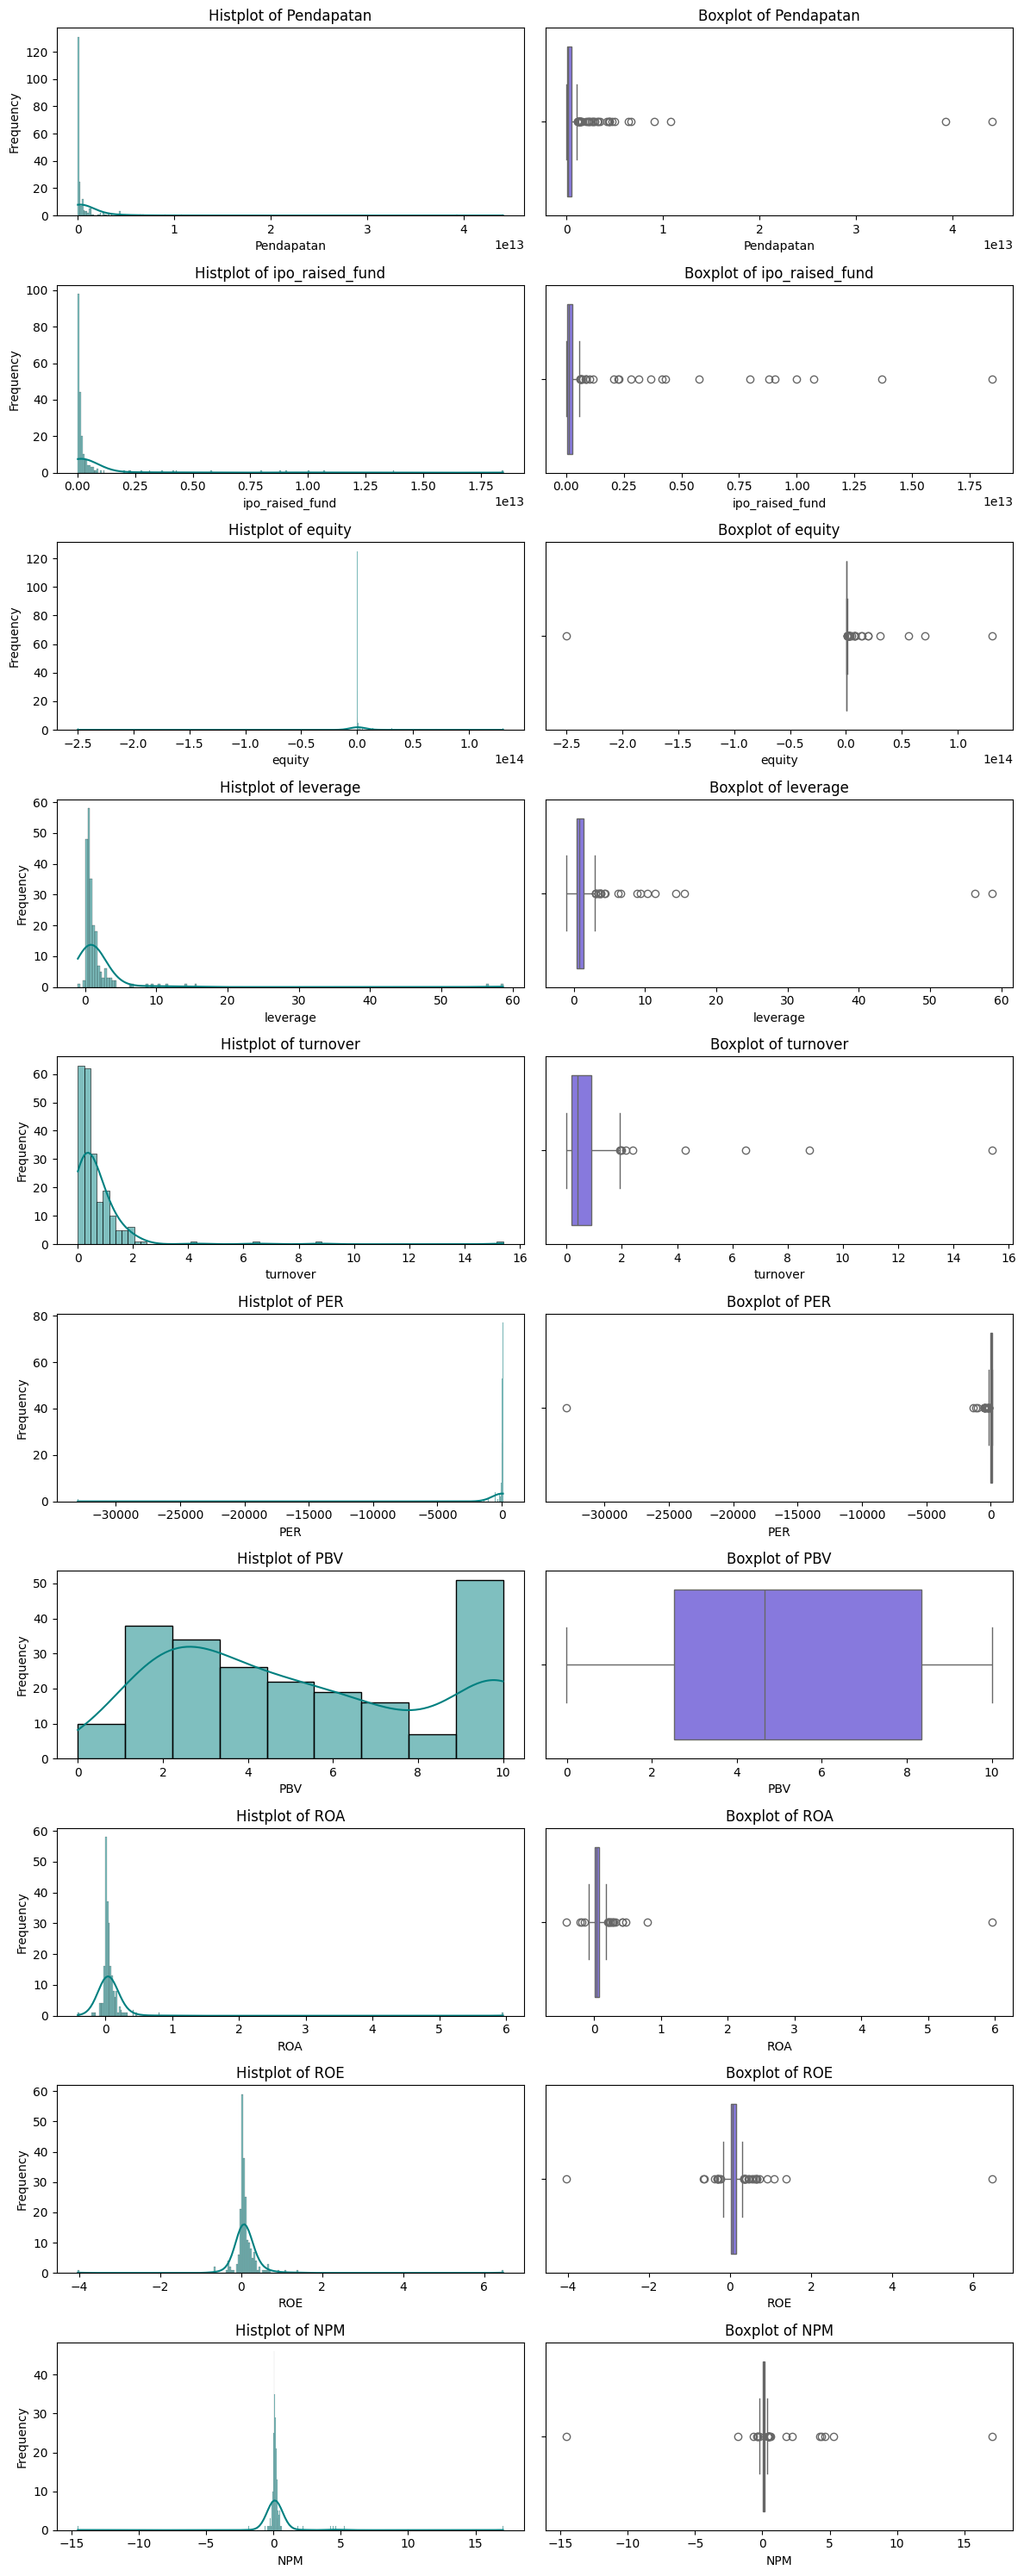

In [489]:
financial_cols = [
    'Pendapatan', 'ipo_raised_fund', 'equity', 'leverage', 'turnover',
    'PER', 'PBV', 'ROA', 'ROE', 'NPM'
]

fig, axes = plt.subplots(len(financial_cols), 2, figsize=(12, 3 * len(financial_cols)))

for idx, col in enumerate(financial_cols):
    data = df[col]

    sns.histplot(data, ax=axes[idx, 0], kde=True, color='teal')
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    sns.boxplot(x=data, ax=axes[idx, 1], orient='h', color='mediumslateblue')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

In [490]:
def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

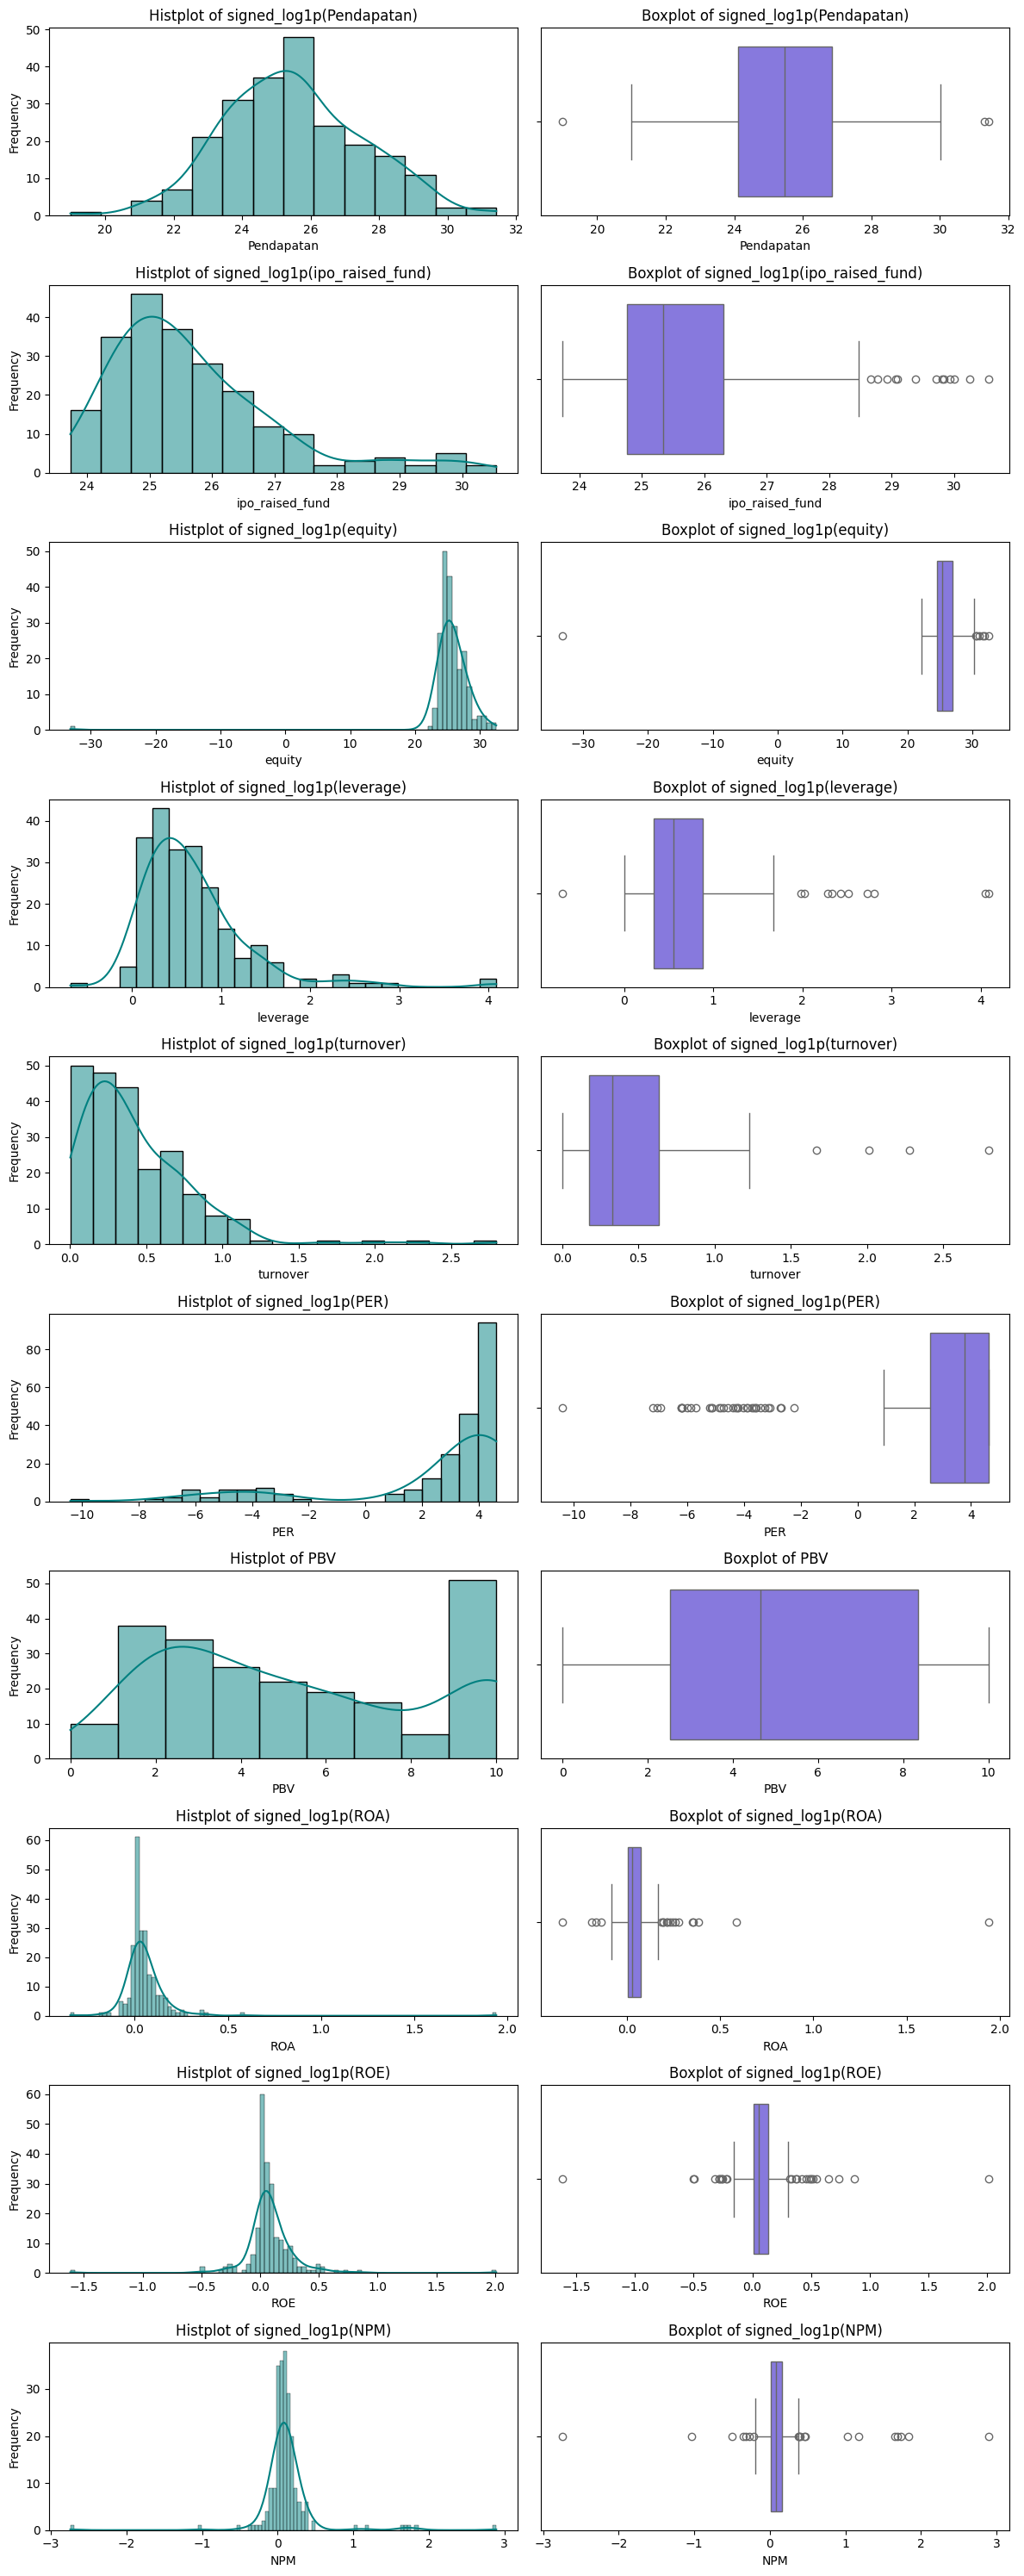

In [491]:
fig, axes = plt.subplots(len(financial_cols), 2, figsize=(12, 3 * len(financial_cols)))

for idx, col in enumerate(financial_cols):
    data = df[col]

    if col != 'PBV':  
        data = signed_log1p(data)

    sns.histplot(data, ax=axes[idx, 0], kde=True, color='teal')
    axes[idx, 0].set_title(f'Histplot of {"signed_log1p(" + col + ")" if col != "PBV" else col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')

    sns.boxplot(x=data, ax=axes[idx, 1], orient='h', color='mediumslateblue')
    axes[idx, 1].set_title(f'Boxplot of {"signed_log1p(" + col + ")" if col != "PBV" else col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

### 5. Rencana Penggunaan Dana

In [492]:
df['Rencana Penggunaan Dana IPO'].value_counts()

Rencana Penggunaan Dana IPO
modal kerja      100
modal belanja     71
ekspansi          26
bayar hutang      23
belanja modal      3
Name: count, dtype: int64

In [493]:
df['Rencana Penggunaan Dana IPO'] = np.where(
    df['Rencana Penggunaan Dana IPO'] == 'bayar hutang',
    'bayar hutang',
    'modal perusahaan'
)

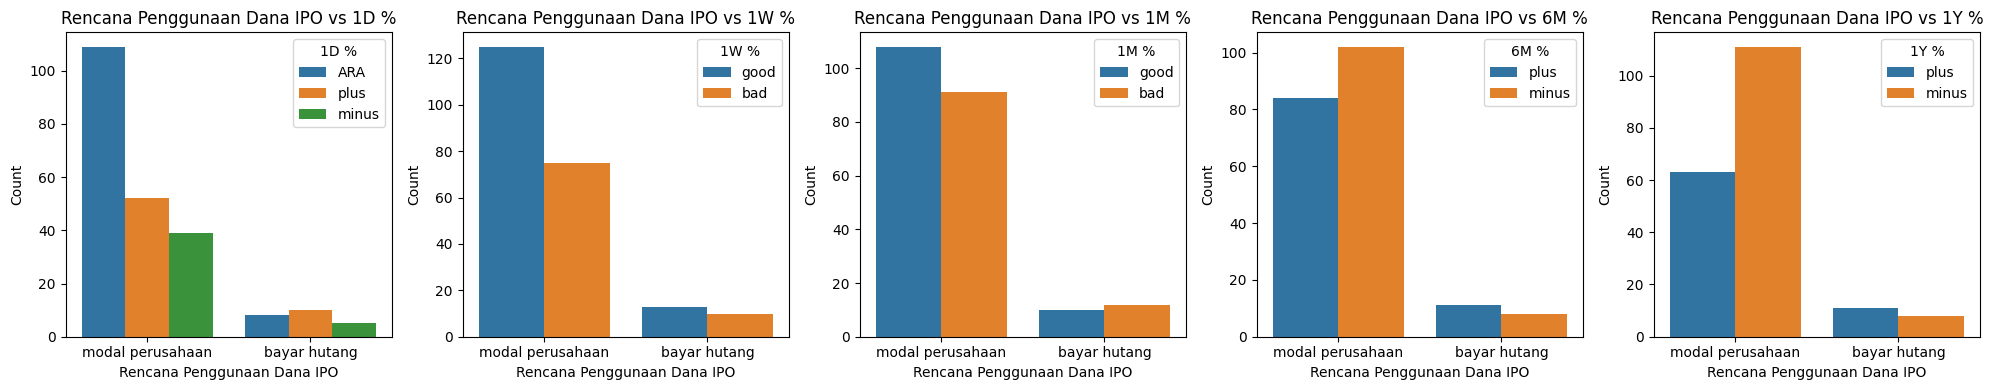

In [494]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(cols):
    sns.countplot(x='Rencana Penggunaan Dana IPO', hue=col, data=df, hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'Rencana Penggunaan Dana IPO vs {col}')
    axes[i].set_xlabel('Rencana Penggunaan Dana IPO')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')

plt.tight_layout()
plt.show()

- Karena data sedikit dan terlalu imbalance, maka kolom ini tidak digunakan untuk menghindari overfitting

### 6. Drop yang ga dipake

In [495]:
df = df.drop(['Listed Share', 'Rencana Penggunaan Dana IPO', 'Valuation Currency', 'Total Liabilitas', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)'], axis=1)

### 7. Total Aset (Numeric -> Category)

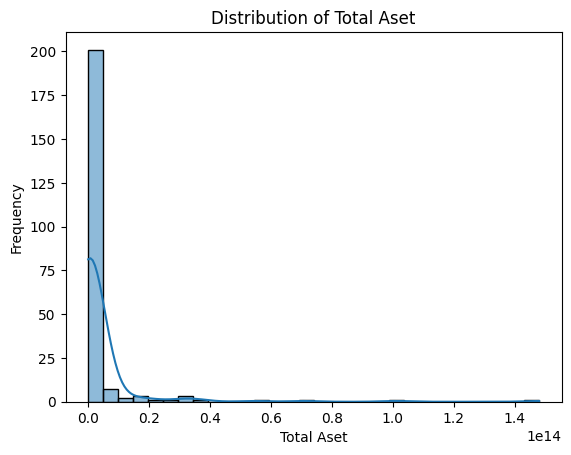

In [496]:
sns.histplot(data=df, x='Total Aset', kde=True, bins=30)
plt.title('Distribution of Total Aset')
plt.xlabel('Total Aset')
plt.ylabel('Frequency')
plt.show()

In [497]:
df['Total Aset'].describe()

count    2.230000e+02
mean     3.591946e+12
std      1.423298e+13
min      1.249215e+10
25%      7.866021e+10
50%      2.370000e+11
75%      1.190000e+12
max      1.480000e+14
Name: Total Aset, dtype: float64

In [498]:
df['Total Aset'] = np.log1p(df['Total Aset'].clip(lower=1e-9))

In [499]:
df['total_aset_category'] = pd.cut(
    df['Total Aset'],
    bins=[-float('inf'), df['Total Aset'].quantile(0.25), df['Total Aset'].quantile(0.75), float('inf')],
    labels=['low', 'mid', 'high']
)

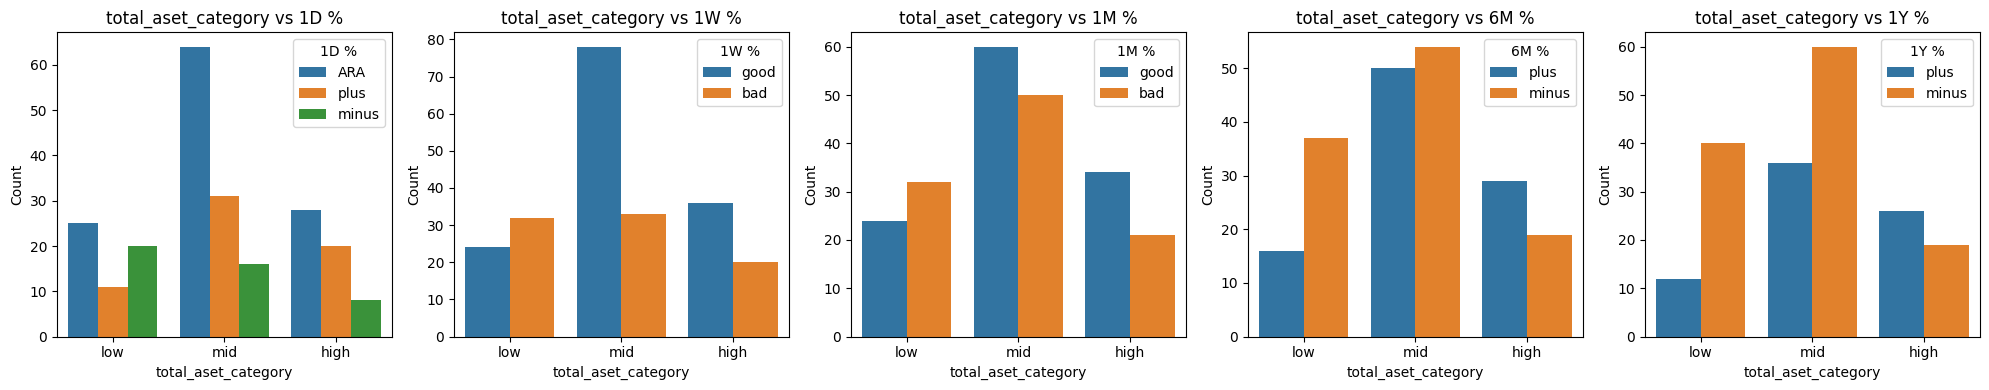

In [500]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['total_aset_category'], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'total_aset_category vs {col}')
    axes[i].set_xlabel('total_aset_category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

- Perusahaan aset tinggi cenderung perform lebih baik

In [501]:
df['total_aset_category'] = df['total_aset_category'].astype('object')

### 8. Harga Final (Numeric -> Category)

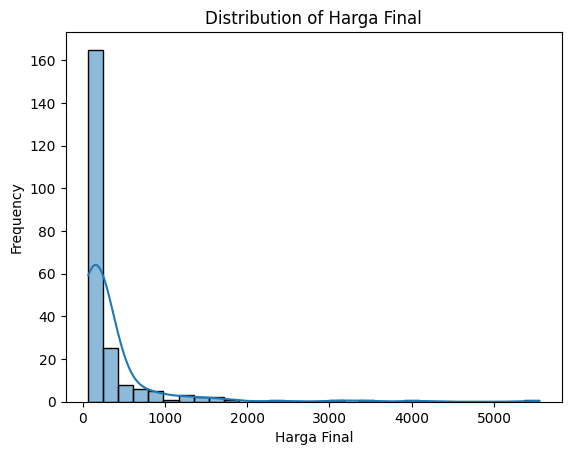

In [502]:
sns.histplot(data=df, x='Harga Final', kde=True, bins=30)
plt.title('Distribution of Harga Final')
plt.xlabel('Harga Final')
plt.ylabel('Frequency')
plt.show()

In [503]:
df['price_category'] = pd.cut(
    df['Harga Final'],
    bins=[-float('inf'), 200, 500, 2000, 5000, float('inf')],
    labels=['penny', 'low', 'medium', 'high', 'premium']
)

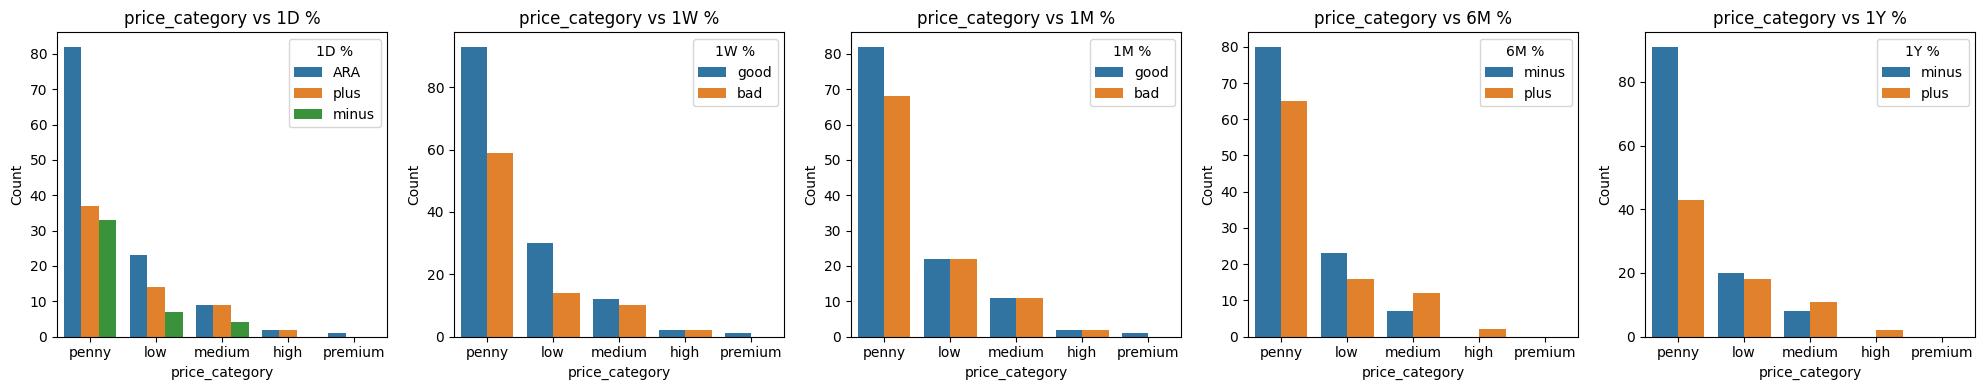

In [504]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['price_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'price_category vs {col}')
    axes[i].set_xlabel('price_category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

In [505]:
df['price_category'] = df['price_category'].astype('object')

## Encoding

In [506]:
df = df.drop('Ticker', axis = 1)
df = df.drop('Nama Perusahaan', axis = 1)

In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sektor                         223 non-null    object 
 1   Underwriter                    223 non-null    object 
 2   Papan Pencatatan               223 non-null    object 
 3   Ownership                      223 non-null    object 
 4   Persen Saham Ditawarkan        223 non-null    float64
 5   Total Aset                     223 non-null    float64
 6   Pendapatan                     223 non-null    float64
 7   Harga Final                    223 non-null    float64
 8   1D %                           223 non-null    object 
 9   1W %                           223 non-null    object 
 10  1M %                           221 non-null    object 
 11  6M %                           205 non-null    object 
 12  1Y %                           193 non-null    obj

In [508]:
categorical_cols = df.select_dtypes(include='object').drop(columns=['Underwriter'])
for col in categorical_cols:
    if col != 'Underwriter' and col != 'lead_underwriter':
        print(f"{col}:")
        print(df[col].unique())
        print('-' * 40)

Sektor:
['Energy' 'Basic Materials' 'Financials' 'Healthcare' 'Technology'
 'Transportation & Logistic' 'Consumer Non-Cyclicals' 'Industrials'
 'Consumer Cyclicals' 'Infrastructures' 'Properties & Real Estate']
----------------------------------------
Papan Pencatatan:
['utama' 'pengembangan' 'pemantauan khusus' 'akselerasi' 'ekonomi baru']
----------------------------------------
Ownership:
['lainnya' 'konglomerat' 'start up' 'bumn']
----------------------------------------
1D %:
['ARA' 'plus' 'minus']
----------------------------------------
1W %:
['good' 'bad']
----------------------------------------
1M %:
['good' 'bad' nan]
----------------------------------------
6M %:
['minus' 'plus' nan]
----------------------------------------
1Y %:
['minus' 'plus' nan]
----------------------------------------
underwriter_freq_category:
['high' 'mid' 'low']
----------------------------------------
underwriter_avg_aset_category:
['low' 'high' 'mid']
----------------------------------------
unde

In [509]:
manual_orders = {
    'Papan Pencatatan': ['utama', 'pengembangan', 'akselerasi', 'ekonomi baru', 'pemantauan khusus'],
    'Ownership': ['bumn', 'konglomerat', 'start up', 'lainnya'],
    'underwriter_freq_category': ['low', 'mid', 'high'],
    'underwriter_avg_aset_category': ['low', 'mid', 'high'],
    'Listing Quartal': ['I', 'II', 'III', 'IV'],
    'total_aset_category': ['low', 'mid', 'high'],
    'price_category': ['penny', 'low', 'medium', 'high', 'premium'],
    'underwriter_highest_short_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_mid_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_long_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_has_bigbank' : ['no', 'yes']
}

label_encoders = {}
encoded_mappings = {}

for col in categorical_cols:
    if col in manual_orders:
        mapping = {v: i for i, v in enumerate(manual_orders[col])}
        df[col] = df[col].map(lambda x: mapping[x] if pd.notna(x) else np.nan)
        encoded_mappings[col] = mapping
        label_encoders[col] = 'manual'
    else:
        le = LabelEncoder()  
        df[col] = df[col].astype("str")
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))  

    df[col] = pd.to_numeric(df[col], errors='coerce')


In [510]:
for col, mapping in encoded_mappings.items():
    print(f"{col}: {mapping}")

Sektor: {'Basic Materials': 0, 'Consumer Cyclicals': 1, 'Consumer Non-Cyclicals': 2, 'Energy': 3, 'Financials': 4, 'Healthcare': 5, 'Industrials': 6, 'Infrastructures': 7, 'Properties & Real Estate': 8, 'Technology': 9, 'Transportation & Logistic': 10}
Papan Pencatatan: {'utama': 0, 'pengembangan': 1, 'akselerasi': 2, 'ekonomi baru': 3, 'pemantauan khusus': 4}
Ownership: {'bumn': 0, 'konglomerat': 1, 'start up': 2, 'lainnya': 3}
1D %: {'ARA': 0, 'minus': 1, 'plus': 2}
1W %: {'bad': 0, 'good': 1}
1M %: {'bad': 0, 'good': 1, 'nan': 2}
6M %: {'minus': 0, 'nan': 1, 'plus': 2}
1Y %: {'minus': 0, 'nan': 1, 'plus': 2}
underwriter_freq_category: {'low': 0, 'mid': 1, 'high': 2}
underwriter_avg_aset_category: {'low': 0, 'mid': 1, 'high': 2}
underwriter_highest_short_rep: {'gamma': 0, 'beta': 1, 'alpha': 2}
underwriter_highest_mid_rep: {'gamma': 0, 'beta': 1, 'alpha': 2}
underwriter_highest_long_rep: {'gamma': 0, 'beta': 1, 'alpha': 2}
underwriter_has_bigbank: {'no': 0, 'yes': 1}
Listing Quartal:

## Correlation

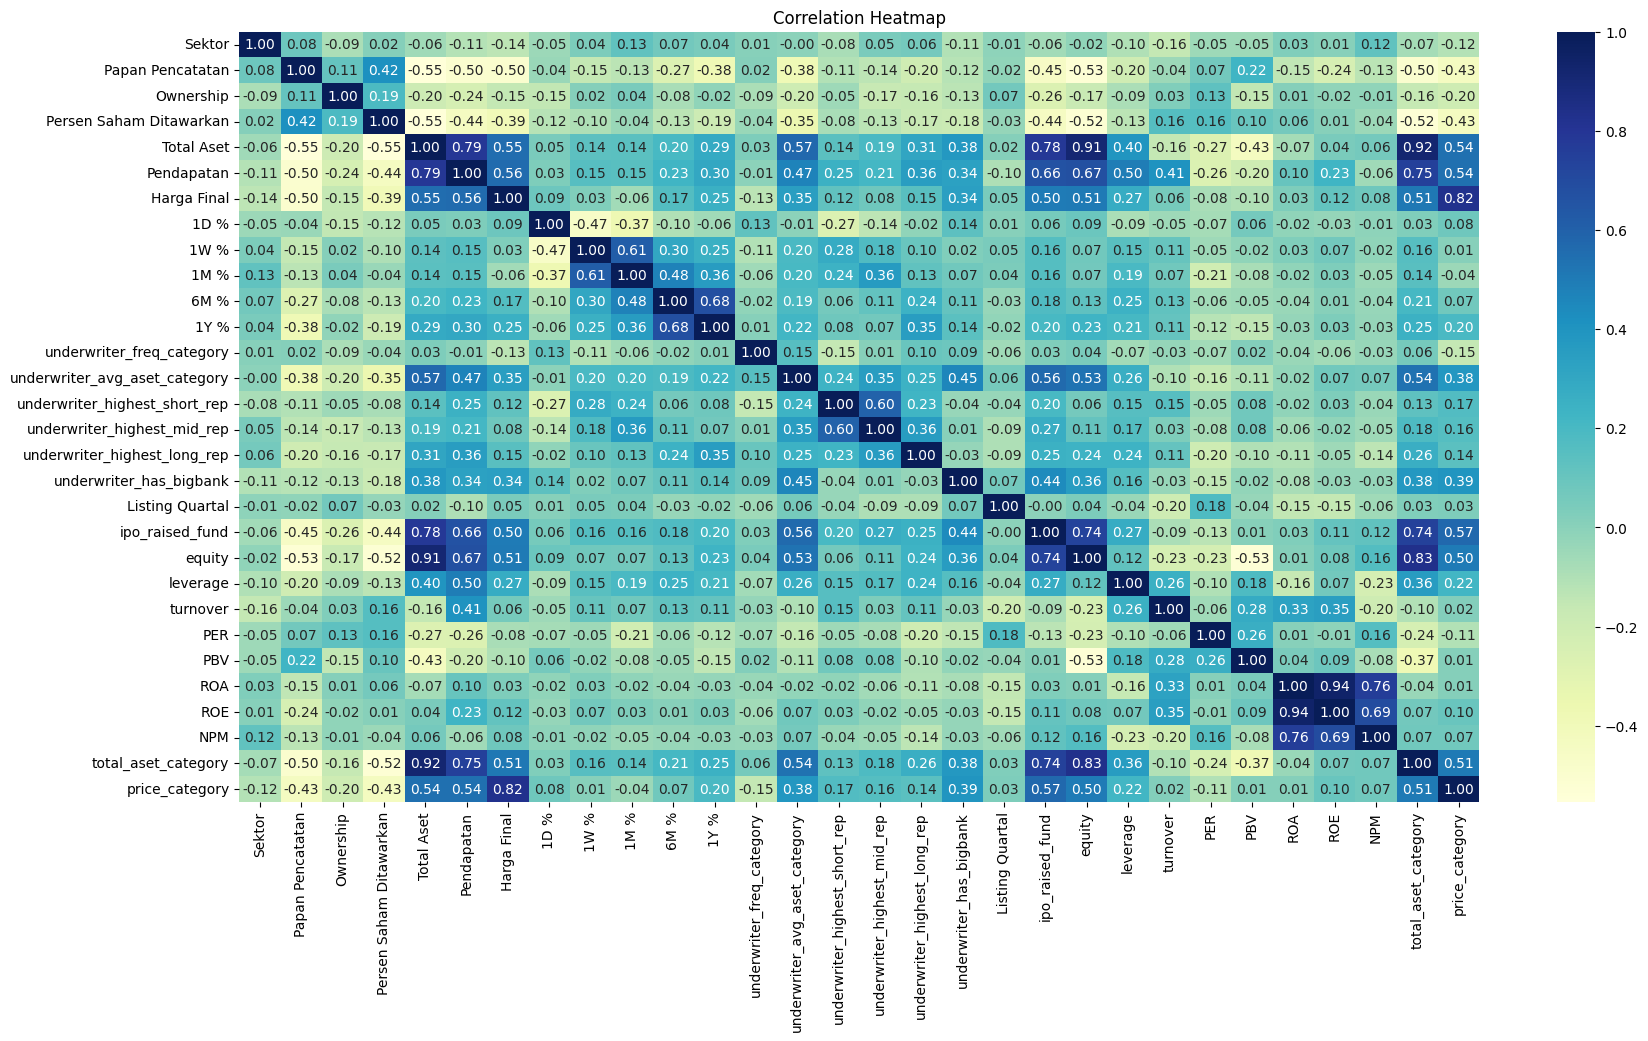

In [513]:
corr_df = df.drop(columns=['Underwriter'])
corr_matrix = corr_df.corr(method='spearman')

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [515]:
# buat save dataset terpisah yang udah diolah

custom_columns = [
    ('Ownership', 'ownership'),    
    ('Papan Pencatatan', 'papan_pencatatan'),
    ('ipo_raised_fund', 'ipo_raised_fund'),    
    ('Persen Saham Ditawarkan', 'float'),    
    ('price_category', 'price_cat'),

    ('underwriter_freq_category', 'underwriter_freq_cat'),
    ('underwriter_avg_aset_category', 'underwriter_avg_aset_cat'),
    ('underwriter_highest_short_rep', 'underwriter_highest_short_rep'),
    ('underwriter_highest_mid_rep', 'underwriter_highest_mid_rep'),    
    ('underwriter_highest_long_rep', 'underwriter_highest_long_rep'),
    ('underwriter_has_bigbank', 'underwriter_has_bigbank'),

    ('total_aset_category', 'total_aset_cat'),
    ('equity', 'equity'),
    ('leverage', 'leverage_ratio'),
    ('Pendapatan', 'revenue'),    
    ('turnover', 'turnover_ratio'),
    ('PER', 'per'),
    ('PBV', 'pbv'),

    ('1D %', '1d'),
    ('1W %', '1w'),
    ('1M %', '1m'),
    ('6M %', '6m'),
    ('1Y %', '1y'),
]

orig_cols, new_names = zip(*custom_columns)

df_custom = df[list(orig_cols)].copy()
df_custom.columns = new_names

df_custom.head()

,ownership,papan_pencatatan,ipo_raised_fund,float,price_cat,underwriter_freq_cat,underwriter_avg_aset_cat,underwriter_highest_short_rep,underwriter_highest_mid_rep,underwriter_highest_long_rep,...,leverage_ratio,revenue,turnover_ratio,per,pbv,1d,1w,1m,6m,1y
0,3,0,3.541024e+10,0.0956,0,2,0,2,2,0,...,0.978022,2.710000e+11,0.501852,-65.942673,1.356777,0,1,1,0,0
1,1,1,2.793938e+12,0.1500,2,2,2,1,1,0,...,3.090090,4.960000e+12,0.546256,12.500839,8.390203,2,0,0,0,0
2,3,4,6.183591e+11,0.1500,3,1,2,2,0,2,...,10.315789,1.210000e+12,0.056279,38.170315,2.169681,0,0,0,2,2
3,1,0,2.123667e+11,0.0726,1,2,2,2,2,2,...,1.057143,1.150000e+12,0.532407,24.789504,2.785868,0,1,1,2,2
4,3,1,5.000000e+10,0.2500,0,2,1,2,2,1,...,0.465612,1.940000e+11,4.292289,100.000000,6.485393,0,1,1,2,2


In [516]:
df_custom.to_csv('processed-data.csv', index=False)